In [1]:
import anndata
import celloracle as co
import dynamo as dyn
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy as scp
from scipy import sparse
from scipy.integrate import solve_ivp
import scipy.interpolate as interp
from scipy.signal import convolve2d
from scipy.spatial.distance import squareform
import scHopfield as sch
import seaborn as sns
import sys
from tqdm import tqdm

which: no R in (/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/envs/SCH/bin:/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/condabin:/opt/slurm/puppet/bin:/usr/share/Modules/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/scripts/bin:/opt/puppetlabs/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin)
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [2]:
%matplotlib inline

In [3]:
os.listdir(".")

['data',
 'figures',
 'out',
 'dcgm',
 'jupyter-server-cpu-04h.sh',
 'jupyter-server-cpu-n_hours.sh',
 'jupyter-server-gpu-04h.sh',
 'jupyter-server-gpu-n_hours.sh',
 'spatial_vae_run1',
 'mygene_cache',
 'spatial_vae_gencode']

In [4]:
# Data configuration
DATA_PATH = '/home/bernaljp/scratch/Data/'  # Update this path
DATASET_NAME = 'Hematopoiesis'
DATASET_FILE = 'hematopoiesis.h5ad'  # Update filename

# Analysis parameters
CLUSTER_KEY = 'cell_type'  # Update to your cluster column name
VELOCITY_KEY = 'velocity_alpha_minus_gamma_s'
SPLICED_KEY = 'M_t'
DEGRADATION_KEY = 'gamma'
DYNAMIC_GENES_KEY = 'use_for_dynamics'

# Order for plotting (update with your cell types)
CELL_TYPE_ORDER = ['HSC', 'MEP-like', 'Ery', 'Meg', 'GMP-like', 'Mon', 'Neu', 'Bas']

# Network inference parameters
N_EPOCHS = 1000
BATCH_SIZE = 128
W_THRESHOLD = 1e-12
SCAFFOLD_REGULARIZATION = 1e-2
DEVICE = 'cuda'  # or 'cpu'

# Visualization parameters
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (10, 6)

## 1. Load and Preprocess Data

In [5]:
print("\n1. Loading data...")
adata = dyn.read_h5ad(DATA_PATH + DATASET_FILE)
print(f"   Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# Remove genes with NaN velocities (Hematopoiesis-specific)
if DATASET_NAME == 'Hematopoiesis':
    print("   Removing genes with NaN velocities...")
    bad_genes = np.unique(np.where(np.isnan(adata.layers[VELOCITY_KEY].toarray()))[1])
    adata = adata[:, ~np.isin(range(adata.n_vars), bad_genes)]
    print(f"   After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Get genes to use for analysis
genes_to_use = adata.var[DYNAMIC_GENES_KEY].values
n_genes = genes_to_use.sum()
print(f"   Using {n_genes} dynamic genes for analysis")


1. Loading data...
   Loaded: 1947 cells × 1956 genes
   Removing genes with NaN velocities...
   After filtering: 1947 cells × 1728 genes
   Using 1728 dynamic genes for analysis


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


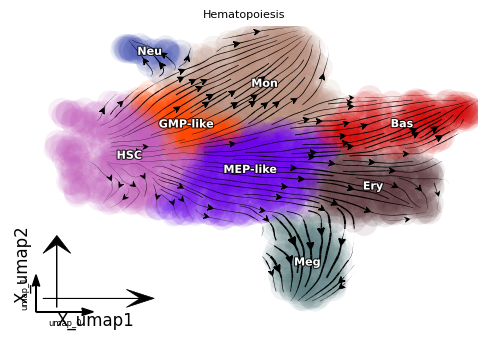

In [6]:
# %%
ax = dyn.pl.streamline_plot(adata, color=CLUSTER_KEY, basis="umap", show_legend="on data", show_arrowed_spines=True, size=(15,10), save_show_or_return='return')
ax[0].set_title("Hematopoiesis")
plt.show()

# %%
colors = {k:ax[0].get_children()[0]._facecolors[np.where(adata.obs[CLUSTER_KEY]==k)[0][0]] for k in adata.obs[CLUSTER_KEY].unique()}
for k in colors:
    colors[k][3] = 1

## 2. Load Scaffold from CellOracle

In [7]:
print("\n2. Loading CellOracle scaffold...")
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

# Create scaffold matrix
scaffold = pd.DataFrame(
    0,
    index=adata.var.index[genes_to_use],
    columns=adata.var.index[genes_to_use]
)

# Convert gene names to lowercase for case-insensitive comparison
tfs = list(set(base_GRN.columns.str.lower()) & set(scaffold.index.str.lower()))
target_genes = list(set(base_GRN['gene_short_name'].str.lower().values) & set(scaffold.columns.str.lower()))

# Map original names for assignment
index_map = {gene.lower(): gene for gene in scaffold.index}
col_map = {gene.lower(): gene for gene in scaffold.columns}

# Fill scaffold with 1s where connections exist
for tf in tfs:
    tf_original = index_map[tf]
    tf_base_GRN = [col for col in base_GRN.columns if col.lower() == tf][0]

    for target in base_GRN[base_GRN[tf_base_GRN] == 1]['gene_short_name']:
        if target.lower() in target_genes:
            target_original = col_map[target.lower()]
            scaffold.loc[tf_original, target_original] = 1

print(f"   Scaffold created: {scaffold.sum().sum()} potential connections")
print(f"   TFs: {len(tfs)}, Target genes: {len(target_genes)}")


2. Loading CellOracle scaffold...
   Scaffold created: 41693 potential connections
   TFs: 73, Target genes: 1148


In [8]:
sch.pp.fit_all_sigmoids(adata,
                         spliced_key=SPLICED_KEY,
                         genes=adata.var['use_for_dynamics'].values)

sch.pp.compute_sigmoid(adata, spliced_key=SPLICED_KEY, copy=False)

/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


In [9]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [10]:
sch.inf.fit_interactions(adata,
                         cluster_key=CLUSTER_KEY,
                         spliced_key=SPLICED_KEY,
                         velocity_key=VELOCITY_KEY,
                         degradation_key=DEGRADATION_KEY,
                         w_threshold=1e-12,
                         w_scaffold=scaffold.values,
                         scaffold_regularization=1e-2,
                         only_TFs=True,
                         infer_I=True,
                         refit_gamma=False,
                         pre_initialize_W=False,
                         n_epochs=1000,
                         criterion='MSE',
                         batch_size=128,
                         skip_all=True,
                         use_scheduler=True,
                         get_plots=False,
                         device='cuda')

Inferring interaction matrix W and bias vector I for cluster Mon


/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))
Training Epochs:   1%|▏         | 14/1000 [00:00<00:14, 70.05it/s]

[Epoch 1/1000] Total Loss: 1510.492981, Reconstruction Loss: 10.101753, Batch size: 39


Training Epochs:  12%|█▏        | 118/1000 [00:01<00:06, 127.14it/s]

[Epoch 101/1000] Total Loss: 594.507538, Reconstruction Loss: 0.067734, Batch size: 39


Training Epochs:  22%|██▏       | 222/1000 [00:01<00:06, 129.11it/s]

[Epoch 201/1000] Total Loss: 484.275909, Reconstruction Loss: 0.015008, Batch size: 39


Training Epochs:  33%|███▎      | 326/1000 [00:02<00:05, 129.28it/s]

[Epoch 301/1000] Total Loss: 443.225937, Reconstruction Loss: 0.002908, Batch size: 39


Training Epochs:  42%|████▏     | 417/1000 [00:03<00:04, 129.05it/s]

[Epoch 401/1000] Total Loss: 426.899689, Reconstruction Loss: 0.001481, Batch size: 39


Training Epochs:  52%|█████▏    | 523/1000 [00:04<00:03, 129.49it/s]

[Epoch 501/1000] Total Loss: 420.204163, Reconstruction Loss: 0.001320, Batch size: 39


Training Epochs:  61%|██████▏   | 614/1000 [00:04<00:02, 129.38it/s]

[Epoch 601/1000] Total Loss: 417.499519, Reconstruction Loss: 0.001321, Batch size: 39


Training Epochs:  72%|███████▏  | 719/1000 [00:05<00:02, 129.30it/s]

[Epoch 701/1000] Total Loss: 416.416405, Reconstruction Loss: 0.001336, Batch size: 39


Training Epochs:  82%|████████▏ | 823/1000 [00:06<00:01, 128.88it/s]

[Epoch 801/1000] Total Loss: 415.982323, Reconstruction Loss: 0.001363, Batch size: 39


Training Epochs:  91%|█████████▏| 914/1000 [00:07<00:00, 128.40it/s]

[Epoch 901/1000] Total Loss: 415.808899, Reconstruction Loss: 0.001353, Batch size: 39


Training Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 127.11it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750542, Reconstruction Loss: 0.001318, Batch size: 39
Inferring interaction matrix W and bias vector I for cluster Meg


Training Epochs:   3%|▎         | 27/1000 [00:00<00:03, 264.16it/s]

[Epoch 1/1000] Total Loss: 1425.262634, Reconstruction Loss: 19.815071, Batch size: 26


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:03, 274.65it/s]

[Epoch 101/1000] Total Loss: 632.249725, Reconstruction Loss: 0.136501, Batch size: 26


Training Epochs:  25%|██▌       | 251/1000 [00:00<00:02, 272.34it/s]

[Epoch 201/1000] Total Loss: 500.734192, Reconstruction Loss: 0.020560, Batch size: 26


Training Epochs:  34%|███▎      | 335/1000 [00:01<00:02, 272.09it/s]

[Epoch 301/1000] Total Loss: 449.455063, Reconstruction Loss: 0.007939, Batch size: 26


Training Epochs:  45%|████▍     | 447/1000 [00:01<00:02, 275.83it/s]

[Epoch 401/1000] Total Loss: 429.256393, Reconstruction Loss: 0.006811, Batch size: 26


Training Epochs:  53%|█████▎    | 531/1000 [00:01<00:01, 277.44it/s]

[Epoch 501/1000] Total Loss: 421.126709, Reconstruction Loss: 0.006603, Batch size: 26


Training Epochs:  64%|██████▍   | 644/1000 [00:02<00:01, 278.60it/s]

[Epoch 601/1000] Total Loss: 417.853882, Reconstruction Loss: 0.006560, Batch size: 26


Training Epochs:  76%|███████▌  | 756/1000 [00:02<00:00, 278.56it/s]

[Epoch 701/1000] Total Loss: 416.559799, Reconstruction Loss: 0.006613, Batch size: 26


Training Epochs:  84%|████████▍ | 840/1000 [00:03<00:00, 278.52it/s]

[Epoch 801/1000] Total Loss: 416.044418, Reconstruction Loss: 0.006514, Batch size: 26


Training Epochs:  95%|█████████▌| 953/1000 [00:03<00:00, 278.70it/s]

[Epoch 901/1000] Total Loss: 415.836777, Reconstruction Loss: 0.006805, Batch size: 26


Training Epochs: 100%|██████████| 1000/1000 [00:03<00:00, 276.23it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.757019, Reconstruction Loss: 0.006740, Batch size: 26
Inferring interaction matrix W and bias vector I for cluster MEP-like


Training Epochs:   1%|          | 11/1000 [00:00<00:09, 107.15it/s]

[Epoch 1/1000] Total Loss: 1503.699875, Reconstruction Loss: 5.294674, Batch size: 73


Training Epochs:  12%|█▏        | 115/1000 [00:00<00:06, 126.53it/s]

[Epoch 101/1000] Total Loss: 594.210159, Reconstruction Loss: 0.045774, Batch size: 73


Training Epochs:  22%|██▏       | 219/1000 [00:01<00:06, 127.01it/s]

[Epoch 201/1000] Total Loss: 483.670799, Reconstruction Loss: 0.009931, Batch size: 73


Training Epochs:  32%|███▏      | 323/1000 [00:02<00:05, 126.47it/s]

[Epoch 301/1000] Total Loss: 443.551094, Reconstruction Loss: 0.001932, Batch size: 73


Training Epochs:  41%|████▏     | 414/1000 [00:03<00:04, 126.31it/s]

[Epoch 401/1000] Total Loss: 426.958099, Reconstruction Loss: 0.000963, Batch size: 73


Training Epochs:  52%|█████▏    | 518/1000 [00:04<00:03, 126.54it/s]

[Epoch 501/1000] Total Loss: 420.211830, Reconstruction Loss: 0.000844, Batch size: 73


Training Epochs:  62%|██████▏   | 622/1000 [00:04<00:02, 126.64it/s]

[Epoch 601/1000] Total Loss: 417.510353, Reconstruction Loss: 0.000865, Batch size: 73


Training Epochs:  73%|███████▎  | 726/1000 [00:05<00:02, 126.77it/s]

[Epoch 701/1000] Total Loss: 416.420433, Reconstruction Loss: 0.000862, Batch size: 73


Training Epochs:  82%|████████▏ | 817/1000 [00:06<00:01, 126.99it/s]

[Epoch 801/1000] Total Loss: 415.983803, Reconstruction Loss: 0.000867, Batch size: 73


Training Epochs:  92%|█████████▏| 921/1000 [00:07<00:00, 127.00it/s]

[Epoch 901/1000] Total Loss: 415.809296, Reconstruction Loss: 0.000875, Batch size: 73


Training Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 126.55it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750435, Reconstruction Loss: 0.000869, Batch size: 73
Inferring interaction matrix W and bias vector I for cluster Ery


Training Epochs:   2%|▎         | 25/1000 [00:00<00:04, 242.95it/s]

[Epoch 1/1000] Total Loss: 1419.010498, Reconstruction Loss: 13.211451, Batch size: 106


Training Epochs:  15%|█▌        | 150/1000 [00:00<00:03, 246.21it/s]

[Epoch 101/1000] Total Loss: 626.696106, Reconstruction Loss: 0.108098, Batch size: 106


Training Epochs:  25%|██▌       | 250/1000 [00:01<00:03, 247.09it/s]

[Epoch 201/1000] Total Loss: 499.730072, Reconstruction Loss: 0.015892, Batch size: 106


Training Epochs:  35%|███▌      | 350/1000 [00:01<00:02, 246.26it/s]

[Epoch 301/1000] Total Loss: 449.352173, Reconstruction Loss: 0.003702, Batch size: 106


Training Epochs:  45%|████▌     | 450/1000 [00:01<00:02, 246.41it/s]

[Epoch 401/1000] Total Loss: 429.227859, Reconstruction Loss: 0.002284, Batch size: 106


Training Epochs:  55%|█████▌    | 550/1000 [00:02<00:01, 246.36it/s]

[Epoch 501/1000] Total Loss: 421.096588, Reconstruction Loss: 0.002101, Batch size: 106


Training Epochs:  65%|██████▌   | 650/1000 [00:02<00:01, 246.37it/s]

[Epoch 601/1000] Total Loss: 417.850250, Reconstruction Loss: 0.002081, Batch size: 106


Training Epochs:  75%|███████▌  | 750/1000 [00:03<00:01, 246.46it/s]

[Epoch 701/1000] Total Loss: 416.557022, Reconstruction Loss: 0.002080, Batch size: 106


Training Epochs:  85%|████████▌ | 850/1000 [00:03<00:00, 248.10it/s]

[Epoch 801/1000] Total Loss: 416.040314, Reconstruction Loss: 0.002093, Batch size: 106


Training Epochs:  95%|█████████▌| 950/1000 [00:03<00:00, 248.70it/s]

[Epoch 901/1000] Total Loss: 415.832657, Reconstruction Loss: 0.002097, Batch size: 106


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 246.89it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.752533, Reconstruction Loss: 0.002089, Batch size: 106
Inferring interaction matrix W and bias vector I for cluster Bas


Training Epochs:   3%|▎         | 27/1000 [00:00<00:03, 264.15it/s]

[Epoch 1/1000] Total Loss: 1421.148682, Reconstruction Loss: 15.905000, Batch size: 49


Training Epochs:  14%|█▍        | 138/1000 [00:00<00:03, 270.10it/s]

[Epoch 101/1000] Total Loss: 630.983032, Reconstruction Loss: 0.117498, Batch size: 49


Training Epochs:  25%|██▍       | 249/1000 [00:00<00:02, 269.45it/s]

[Epoch 201/1000] Total Loss: 500.077347, Reconstruction Loss: 0.020312, Batch size: 49


Training Epochs:  33%|███▎      | 330/1000 [00:01<00:02, 265.51it/s]

[Epoch 301/1000] Total Loss: 449.390335, Reconstruction Loss: 0.004704, Batch size: 49


Training Epochs:  44%|████▍     | 438/1000 [00:01<00:02, 266.98it/s]

[Epoch 401/1000] Total Loss: 429.234406, Reconstruction Loss: 0.002891, Batch size: 49


Training Epochs:  55%|█████▍    | 546/1000 [00:02<00:01, 267.38it/s]

[Epoch 501/1000] Total Loss: 421.105698, Reconstruction Loss: 0.002738, Batch size: 49


Training Epochs:  65%|██████▌   | 654/1000 [00:02<00:01, 267.34it/s]

[Epoch 601/1000] Total Loss: 417.847870, Reconstruction Loss: 0.002753, Batch size: 49


Training Epochs:  74%|███████▎  | 735/1000 [00:02<00:00, 267.17it/s]

[Epoch 701/1000] Total Loss: 416.557068, Reconstruction Loss: 0.002684, Batch size: 49


Training Epochs:  84%|████████▍ | 843/1000 [00:03<00:00, 267.46it/s]

[Epoch 801/1000] Total Loss: 416.041061, Reconstruction Loss: 0.002727, Batch size: 49


Training Epochs:  95%|█████████▌| 951/1000 [00:03<00:00, 267.18it/s]

[Epoch 901/1000] Total Loss: 415.833130, Reconstruction Loss: 0.002769, Batch size: 49


Training Epochs: 100%|██████████| 1000/1000 [00:03<00:00, 267.64it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.752975, Reconstruction Loss: 0.002606, Batch size: 49
Inferring interaction matrix W and bias vector I for cluster GMP-like


Training Epochs:   3%|▎         | 27/1000 [00:00<00:03, 260.94it/s]

[Epoch 1/1000] Total Loss: 1412.287994, Reconstruction Loss: 6.971267, Batch size: 33


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:03, 272.47it/s]

[Epoch 101/1000] Total Loss: 626.696381, Reconstruction Loss: 0.080318, Batch size: 33


Training Epochs:  25%|██▌       | 251/1000 [00:00<00:02, 273.72it/s]

[Epoch 201/1000] Total Loss: 500.247040, Reconstruction Loss: 0.008682, Batch size: 33


Training Epochs:  34%|███▎      | 335/1000 [00:01<00:02, 274.01it/s]

[Epoch 301/1000] Total Loss: 449.627960, Reconstruction Loss: 0.001565, Batch size: 33


Training Epochs:  45%|████▍     | 447/1000 [00:01<00:02, 274.51it/s]

[Epoch 401/1000] Total Loss: 429.301437, Reconstruction Loss: 0.000747, Batch size: 33


Training Epochs:  53%|█████▎    | 531/1000 [00:01<00:01, 272.93it/s]

[Epoch 501/1000] Total Loss: 421.139999, Reconstruction Loss: 0.000653, Batch size: 33


Training Epochs:  64%|██████▍   | 643/1000 [00:02<00:01, 274.06it/s]

[Epoch 601/1000] Total Loss: 417.867874, Reconstruction Loss: 0.000611, Batch size: 33


Training Epochs:  76%|███████▌  | 755/1000 [00:02<00:00, 274.32it/s]

[Epoch 701/1000] Total Loss: 416.563934, Reconstruction Loss: 0.000652, Batch size: 33


Training Epochs:  84%|████████▍ | 839/1000 [00:03<00:00, 274.02it/s]

[Epoch 801/1000] Total Loss: 416.042313, Reconstruction Loss: 0.000617, Batch size: 33


Training Epochs:  95%|█████████▌| 951/1000 [00:03<00:00, 274.22it/s]

[Epoch 901/1000] Total Loss: 415.832535, Reconstruction Loss: 0.000668, Batch size: 33


Training Epochs: 100%|██████████| 1000/1000 [00:03<00:00, 273.61it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.751556, Reconstruction Loss: 0.000616, Batch size: 33
Inferring interaction matrix W and bias vector I for cluster HSC


Training Epochs:   2%|▏         | 17/1000 [00:00<00:05, 165.77it/s]

[Epoch 1/1000] Total Loss: 1602.362630, Reconstruction Loss: 4.424540, Batch size: 53


Training Epochs:  12%|█▎        | 125/1000 [00:00<00:05, 173.53it/s]

[Epoch 101/1000] Total Loss: 605.800598, Reconstruction Loss: 0.060061, Batch size: 53


Training Epochs:  23%|██▎       | 233/1000 [00:01<00:04, 173.73it/s]

[Epoch 201/1000] Total Loss: 493.836202, Reconstruction Loss: 0.009619, Batch size: 53


Training Epochs:  32%|███▏      | 323/1000 [00:01<00:03, 173.44it/s]

[Epoch 301/1000] Total Loss: 447.446493, Reconstruction Loss: 0.002328, Batch size: 53


Training Epochs:  43%|████▎     | 431/1000 [00:02<00:03, 171.73it/s]

[Epoch 401/1000] Total Loss: 428.392354, Reconstruction Loss: 0.000826, Batch size: 53


Training Epochs:  52%|█████▏    | 521/1000 [00:03<00:02, 173.06it/s]

[Epoch 501/1000] Total Loss: 420.759847, Reconstruction Loss: 0.000633, Batch size: 53


Training Epochs:  63%|██████▎   | 629/1000 [00:03<00:02, 173.28it/s]

[Epoch 601/1000] Total Loss: 417.716817, Reconstruction Loss: 0.000629, Batch size: 53


Training Epochs:  72%|███████▏  | 719/1000 [00:04<00:01, 173.40it/s]

[Epoch 701/1000] Total Loss: 416.502777, Reconstruction Loss: 0.000651, Batch size: 53


Training Epochs:  83%|████████▎ | 827/1000 [00:04<00:00, 173.45it/s]

[Epoch 801/1000] Total Loss: 416.015849, Reconstruction Loss: 0.000659, Batch size: 53


Training Epochs:  94%|█████████▎| 935/1000 [00:05<00:00, 173.69it/s]

[Epoch 901/1000] Total Loss: 415.821513, Reconstruction Loss: 0.000658, Batch size: 53


Training Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 173.35it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.749095, Reconstruction Loss: 0.000647, Batch size: 53
Inferring interaction matrix W and bias vector I for cluster Neu


Training Epochs:   6%|▌         | 59/1000 [00:00<00:01, 585.35it/s]

[Epoch 1/1000] Total Loss: 723.924377, Reconstruction Loss: 0.467765, Batch size: 32
[Epoch 101/1000] Total Loss: 636.944397, Reconstruction Loss: 0.402602, Batch size: 32


Training Epochs:  31%|███       | 311/1000 [00:00<00:01, 623.20it/s]

[Epoch 201/1000] Total Loss: 507.236664, Reconstruction Loss: 0.038865, Batch size: 32
[Epoch 301/1000] Total Loss: 451.584412, Reconstruction Loss: 0.008601, Batch size: 32


Training Epochs:  50%|█████     | 502/1000 [00:00<00:00, 627.23it/s]

[Epoch 401/1000] Total Loss: 430.522797, Reconstruction Loss: 0.005122, Batch size: 32
[Epoch 501/1000] Total Loss: 421.666260, Reconstruction Loss: 0.004806, Batch size: 32


Training Epochs:  69%|██████▉   | 693/1000 [00:01<00:00, 631.01it/s]

[Epoch 601/1000] Total Loss: 418.065918, Reconstruction Loss: 0.004838, Batch size: 32
[Epoch 701/1000] Total Loss: 416.649445, Reconstruction Loss: 0.004846, Batch size: 32


Training Epochs:  89%|████████▊ | 886/1000 [00:01<00:00, 633.34it/s]

[Epoch 801/1000] Total Loss: 416.078461, Reconstruction Loss: 0.004854, Batch size: 32
[Epoch 901/1000] Total Loss: 415.849731, Reconstruction Loss: 0.004861, Batch size: 32


Training Epochs: 100%|██████████| 1000/1000 [00:01<00:00, 626.98it/s]

[Epoch 1000/1000] Total Loss: 415.757538, Reconstruction Loss: 0.004862, Batch size: 32


# Energies

In [11]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [12]:
# Compute energies using scHopfield
sch.tl.compute_energies(adata, cluster_key=CLUSTER_KEY)

In [13]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [14]:
summary_stats = adata.obs[[CLUSTER_KEY,'energy_total','energy_interaction','energy_degradation','energy_bias']].groupby(CLUSTER_KEY).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]
summary_stats['energy_total']

count       mean       std       min       25%        50%  \
cell_type                                                              
Bas        177.0   7.797723  1.730839  3.723090  6.650828   8.185850   
Ery        234.0   6.891540  1.140073  3.450491  6.320164   6.713969   
GMP-like   161.0   4.354756  0.748311  3.207050  3.771212   4.026600   
HSC        309.0   4.243672  0.601507  3.154034  3.834067   4.116244   
MEP-like   457.0   4.884635  0.953657  3.499254  4.245375   4.597585   
Meg        154.0  10.666936  1.432050  5.757740  9.901544  10.793115   
Mon        423.0   5.776934  0.864707  3.344177  5.495350   5.799909   
Neu         32.0   8.909928  0.388071  7.269811  8.939343   9.009907   

                 75%        max        cv  
cell_type                                  
Bas         9.325467  10.158921  0.221967  
Ery         7.184526  12.061975  0.165431  
GMP-like    5.132639   6.203007  0.171838  
HSC         4.491137   7.278943  0.141742  
MEP-like    5.391329   9.568652  0.195236  
Meg        11.661754  12.910938  0.134251  
Mon         6.097158  12.618494  0.149683  
Neu         9.109122   9.230654  0.043555

array([<Axes3DSubplot: >], dtype=object)

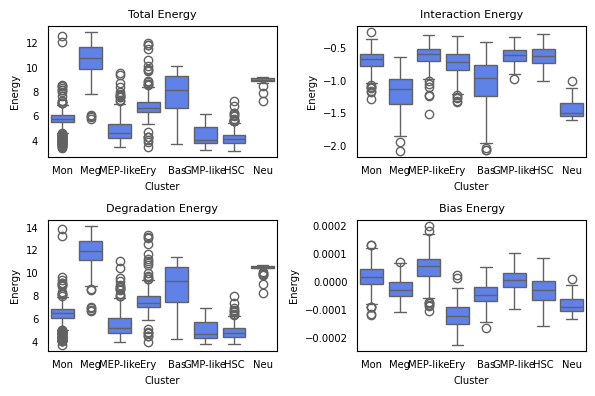

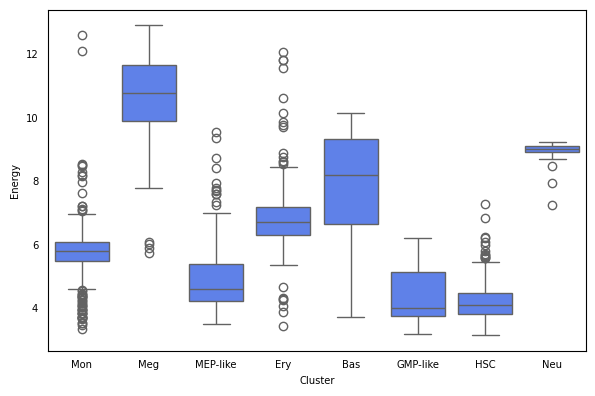

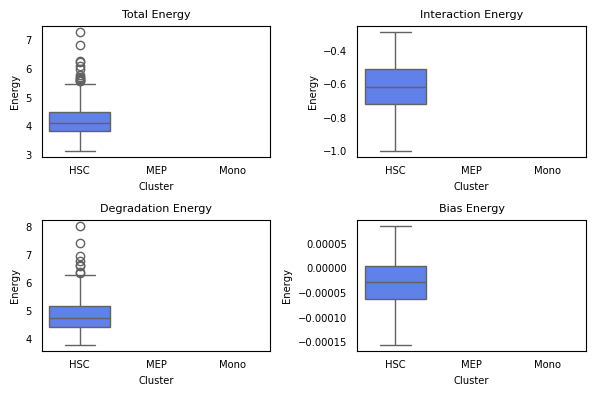

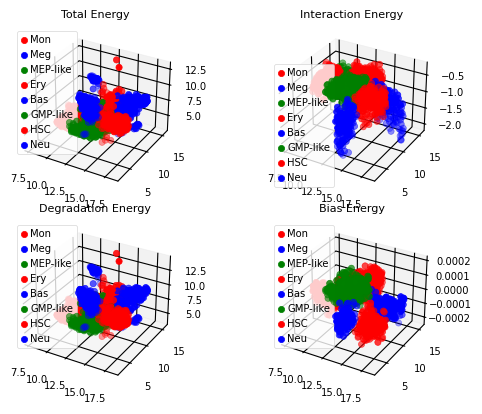

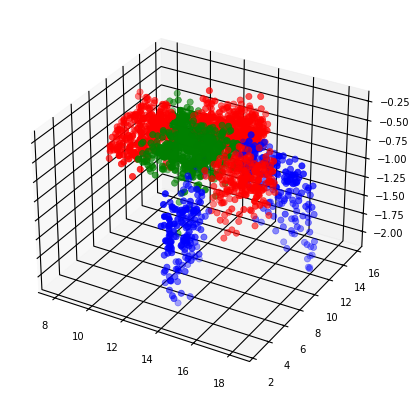

In [15]:
# Plot boxplots for all energy types
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type')

# Plot only total energy boxplot
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type', plot_energy='total')

# Plot with custom order and colors
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type',
                            order=['HSC', 'MEP', 'Mono'],
                            colors=['red', 'blue', 'green'])

# 3D scatter plots
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                            basis='umap', show_legend=True)

# Plot specific energy type
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                              plot_energy='interaction')

# Dendrograms

## Cell type dendrogram

In [16]:
# Compute celltype correlation using scHopfield
sch.tl.celltype_correlation(adata, spliced_key=SPLICED_KEY,cluster_key=CLUSTER_KEY)

<Figure size 900x300 with 0 Axes>

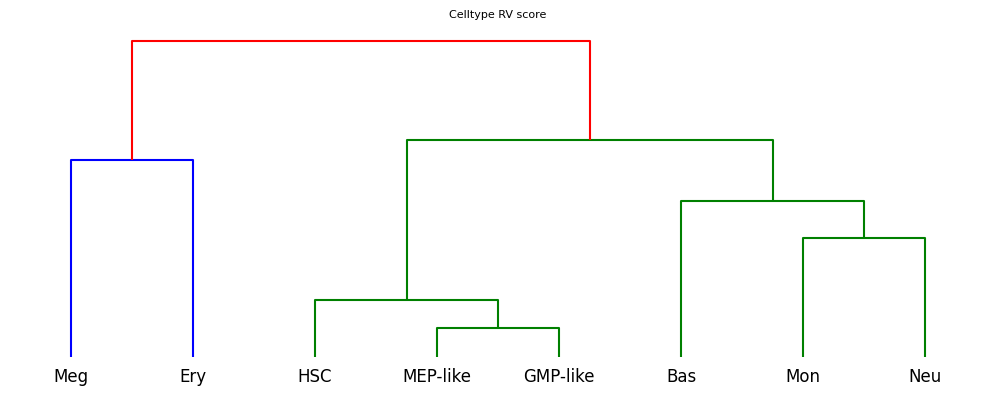

In [17]:
cells_correlation = adata.uns['scHopfield']['celltype_correlation']
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-cells_correlation), 'complete')
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

## Network dendrogram

In [18]:
# Compute network correlations using scHopfield
sch.tl.network_correlations(adata, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [19]:
pearson = adata.uns['scHopfield']['network_correlations']['pearson']
hamming = adata.uns['scHopfield']['network_correlations']['hamming']
pearson_bin = adata.uns['scHopfield']['network_correlations']['pearson_bin']

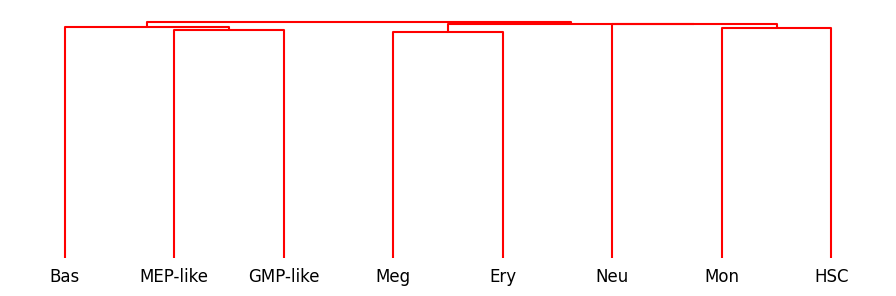

In [20]:
fig,axs = plt.subplots(1,1,figsize=(9, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson.index)
plt.show()

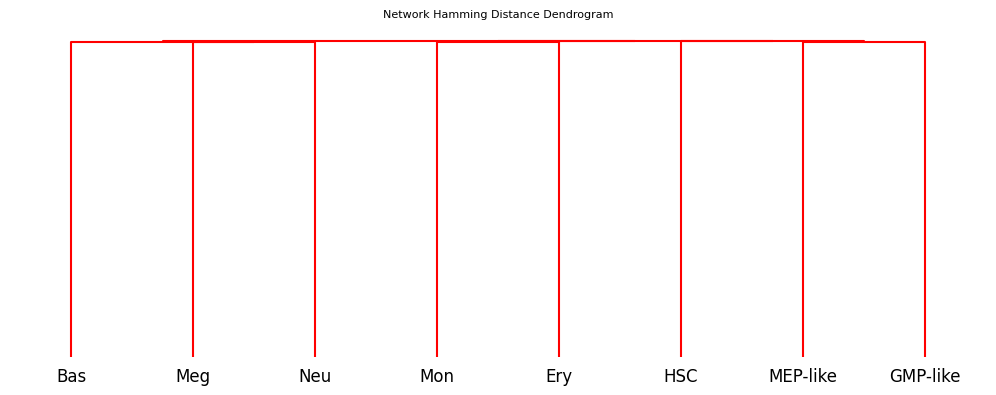

In [21]:
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Network Hamming Distance Dendrogram')

Z = scp.cluster.hierarchy.linkage(squareform(hamming), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = hamming.index)
plt.show()

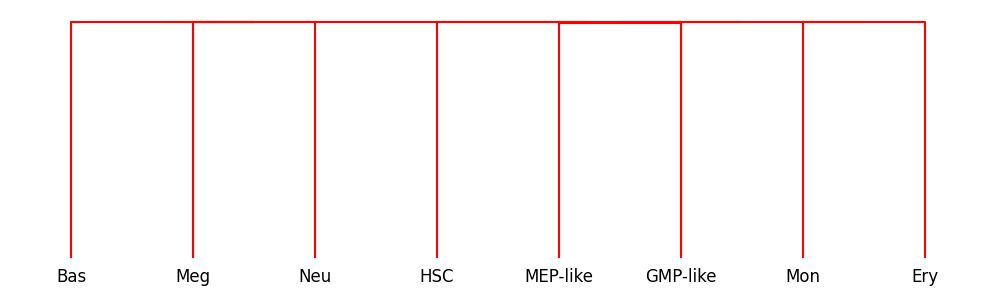

In [22]:
fig,axs = plt.subplots(1,1,figsize=(10, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson_bin), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson_bin.index)
plt.show()

# Symmetricity

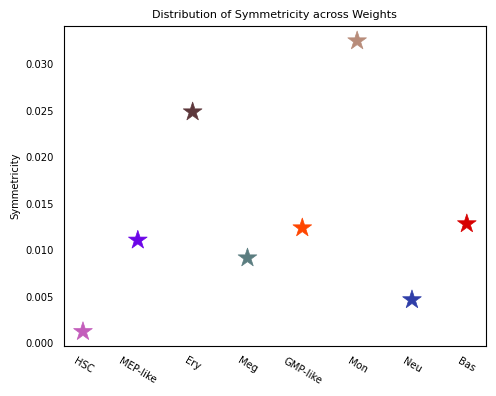

In [23]:
def symmetricity(A, norm=2):
    S = np.linalg.norm((A+A.T)/2, ord=norm)
    As = np.linalg.norm((A-A.T)/2, ord=norm)
    return (S-As)/(S+As)

# Get interaction matrices from scHopfield storage
W = {}
genes_used = adata.var['use_for_dynamics'].values
gene_names = adata.var_names[genes_used]
for cluster in CELL_TYPE_ORDER:
    W[cluster] = adata.varp[f'W_{cluster}'][genes_used][:,genes_used]

syms = np.array([symmetricity(W[k], norm=2) for k in CELL_TYPE_ORDER])
idxs = np.argsort(syms)
plt.figure(figsize=(5,4), tight_layout=True)
plt.scatter(range(len(W)), syms, s=200, marker='*', c=[colors[i] for i in CELL_TYPE_ORDER])
plt.xticks(range(len(W)), np.array(CELL_TYPE_ORDER))
plt.ylabel('Symmetricity')
plt.xticks(rotation=-30)
plt.title('Distribution of Symmetricity across Weights')
plt.show()

# Model Analysis

In [24]:
gamma = {}
I = {}
for cluster in CELL_TYPE_ORDER:
    gamma[cluster] = adata.var[f'gamma_{cluster}'].values[genes_used] if f'gamma_{cluster}' in adata.var.columns else adata.var[DEGRADATION_KEY].values[genes_used]
    I[cluster] = adata.var[f'I_{cluster}'].values[genes_used] if f'I_{cluster}' in adata.var.columns else np.zeros(genes_used.sum())

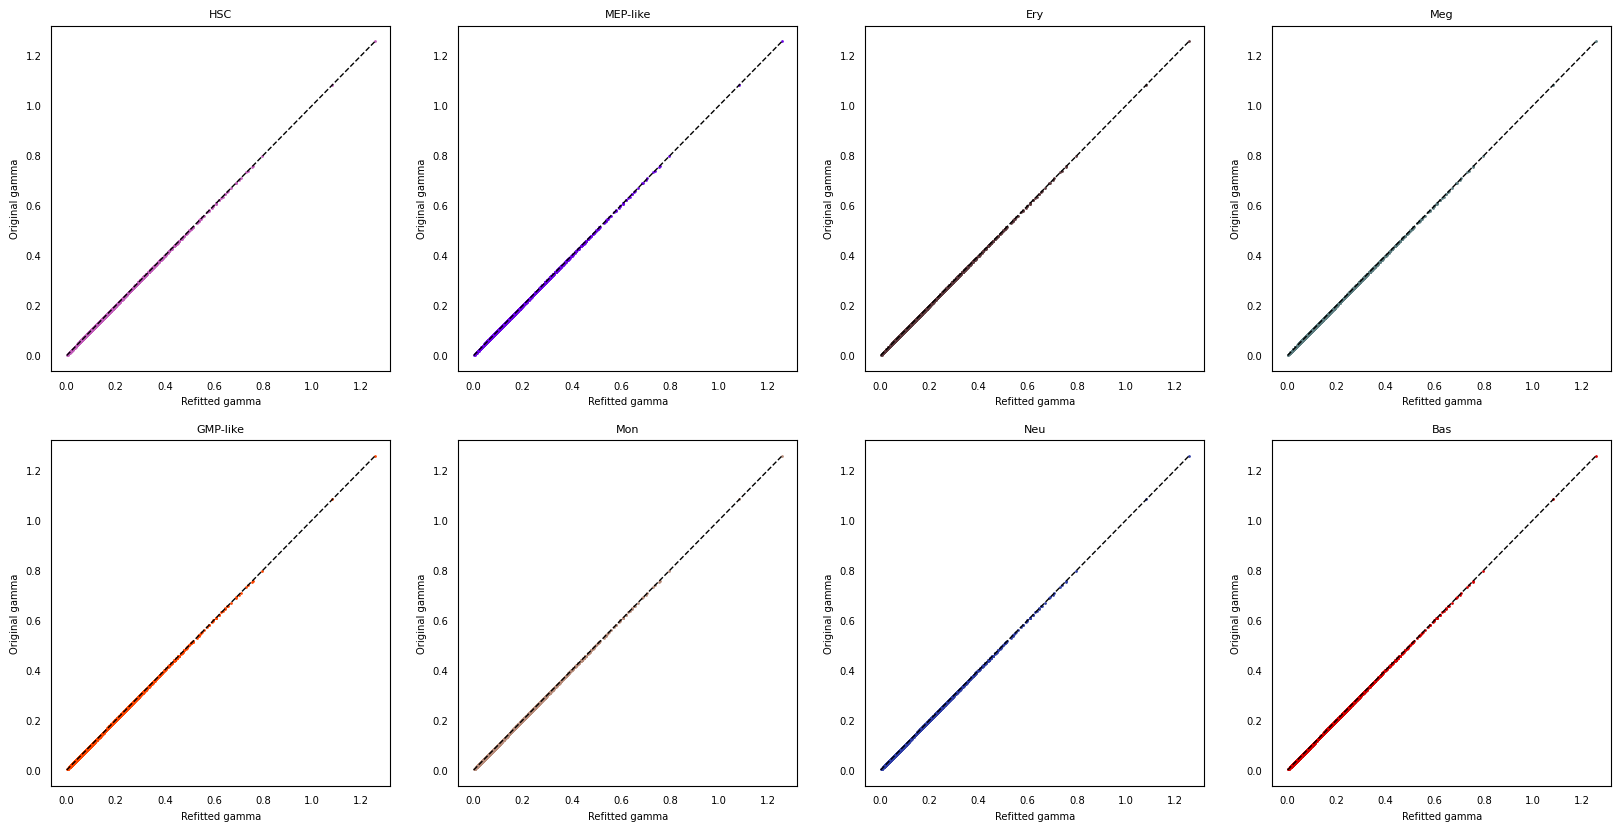

In [25]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
    ax.scatter(gamma[cl], adata.var[DEGRADATION_KEY][genes_used], color=colors[cl], s=2)
    ax.set_title(cl)
    max_gamma = max(np.concatenate([gamma[cl], adata.var[DEGRADATION_KEY][genes_used]]))
    ax.set_xlabel('Refitted gamma')
    ax.set_ylabel('Original gamma')
    ax.plot([0, max_gamma], [0, max_gamma], color='k', ls='--', lw=1)
plt.show()

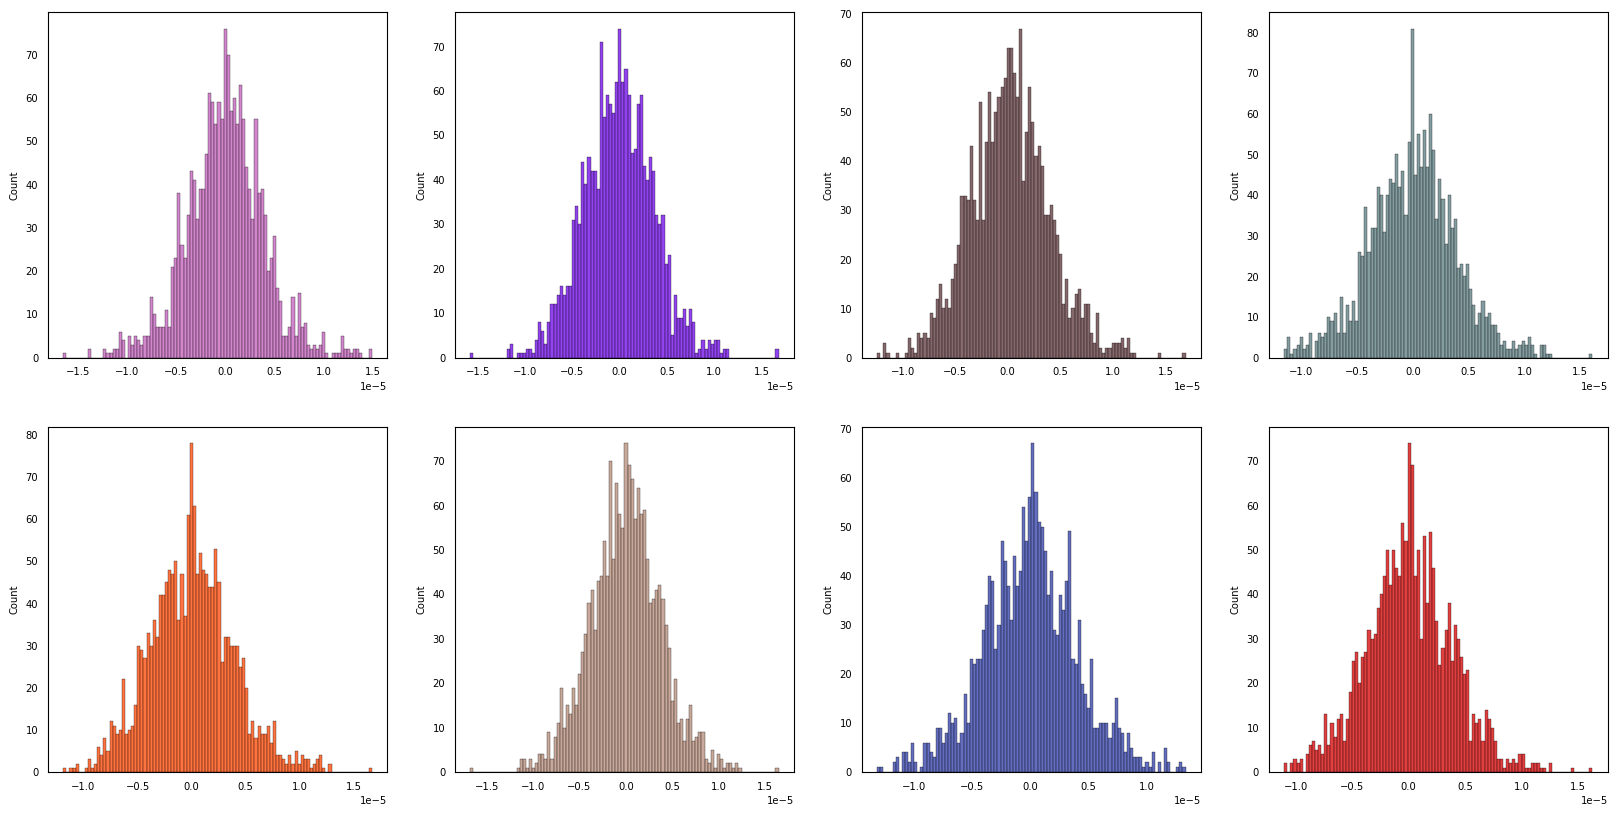

In [26]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
   sns.histplot(I[cl].flatten(), bins=100,ax=ax, color=colors[cl])
plt.show()

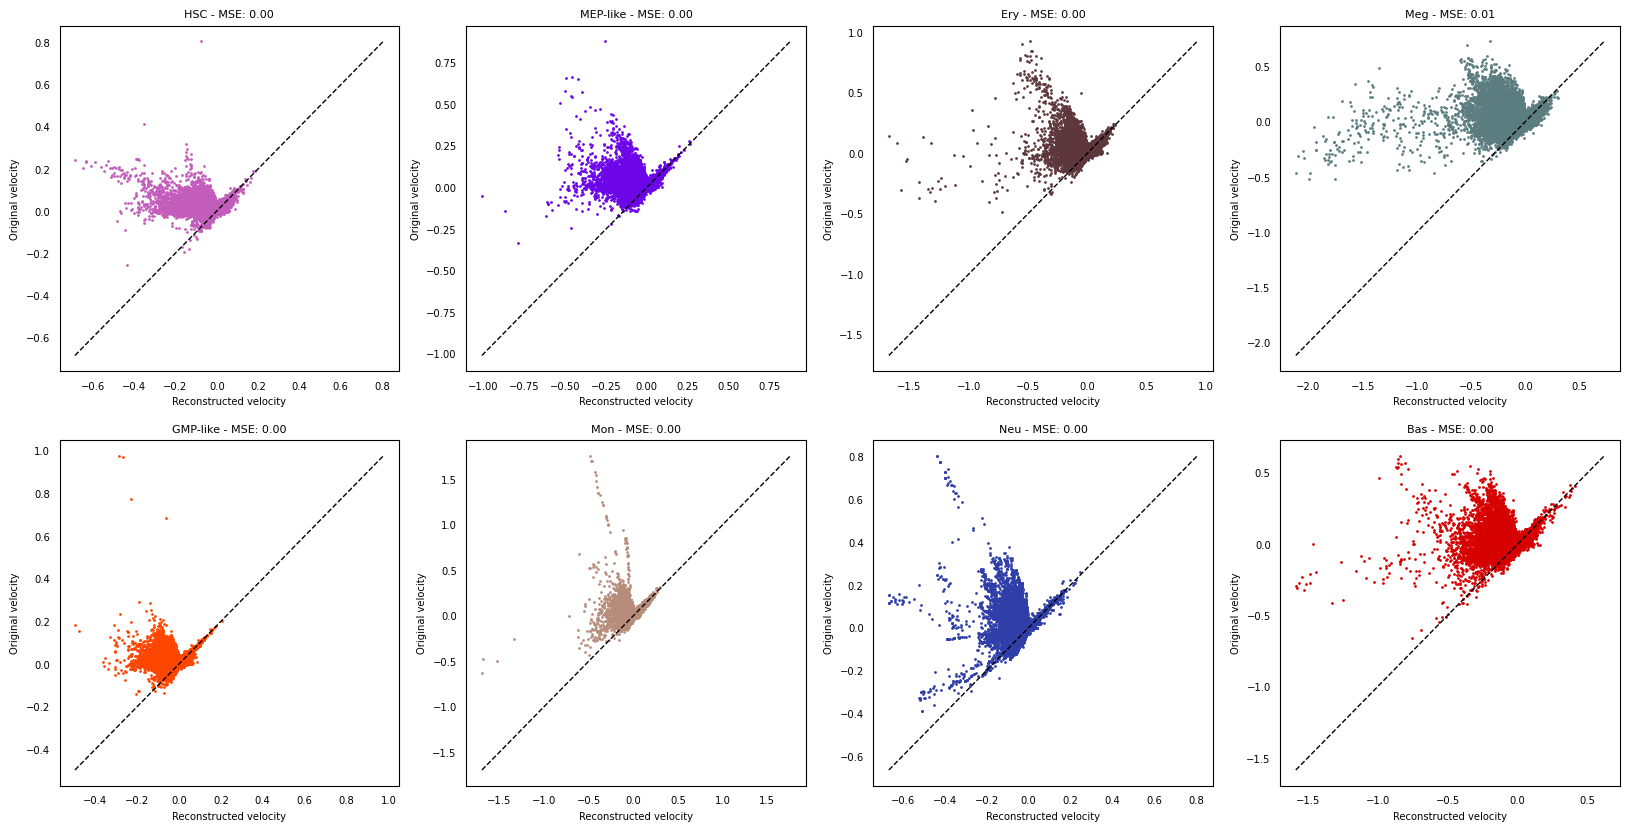

In [27]:
# Get MSE for each cluster
mse_dict = sch.tl.validate_velocity(
    adata,
    velocity_key=VELOCITY_KEY,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    return_mse=False  # Returns dict with per-cluster MSE
)

# Then plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for cl, ax in zip(CELL_TYPE_ORDER, axs.flatten()):
    reconstructed_v = sch.tl.compute_reconstructed_velocity(
        adata, cluster=cl, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY
    )

    genes_used = sch._utils.io.get_genes_used(adata)
    cluster_mask = (adata.obs[CLUSTER_KEY] == cl).values
    original_v = adata.layers[VELOCITY_KEY][cluster_mask][:, genes_used]

    ax.scatter(reconstructed_v.flatten(), original_v.toarray().flatten(), color=colors[cl], s=2)
    ax.set_title(f'{cl} - MSE: {mse_dict[cl]:.2f}')
    ax.set_xlabel('Reconstructed velocity')
    ax.set_ylabel('Original velocity')

    min_v = min(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    max_v = max(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    ax.plot([min_v, max_v], [min_v, max_v], c='k', ls='--', lw=1)

plt.show()

# Correlations

In [28]:
# Compute energy-gene correlations using scHopfield
sch.tl.energy_gene_correlation(adata, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered i

In [29]:
df_correlations = sch.tl.get_correlation_table(
      adata,
      cluster_key=CLUSTER_KEY,
      energy_type='total',  # or 'interaction', 'degradation', 'bias'
      n_top_genes=100,
      order=CELL_TYPE_ORDER  # optional: specify cluster order
  )
df_correlations

HSC                MEP-like                  Ery                Meg  \
        Gene Correlation        Gene Correlation     Gene Correlation   Gene   
0       CRYM    0.738989        RORA    0.830107   DIAPH1    0.852921  LTBP1   
1       RORA    0.706638    SLC30A10    0.820562   ITGA2B    0.832533   GPX1   
2   SLC30A10    0.702435  AC108519.1    0.813818   HEXIM1    0.830038    GSN   
3      TIAM1    0.696651     PGAM1P5    0.811160    PTGS1    0.825281  MMRN1   
4      EXTL3    0.693370       MBNL3    0.810956    IL21R    0.821842  THBS1   
..       ...         ...         ...         ...      ...         ...    ...   
95   PLEKHG3    0.443080       IGF2R    0.553578    F13A1    0.669603    CD9   
96     INTS5    0.442595         EYS    0.553455  ARHGAP6    0.668216   PBX1   
97      APRT    0.442269     SMARCD2    0.549574   SH3BP5    0.667505   MCL1   
98     DDX41    0.441582        CTSD    0.548434  EXOC3L2    0.667231   NFE2   
99  C15orf39    0.441574     CDK2AP2    0.547924    ITGB5    0.667054    ILK   

                  GMP-like                  Mon                    Neu  \
   Correlation        Gene Correlation     Gene Correlation       Gene   
0     0.931910        RORA    0.869840     GPX1    0.687658    S100A11   
1     0.918929     PGAM1P5    0.867502     PPIF    0.686229      FMNL3   
2     0.911457       MBNL3    0.866248  PGAM1P5    0.655891      CD151   
3     0.904706       EXTL3    0.865399     LMNA    0.643866     IL17RA   
4     0.899945       TIAM1    0.860437     PATJ    0.642386      PPM1F   
..         ...         ...         ...      ...         ...        ...   
95    0.738919     PIK3AP1    0.602476   HEXIM1    0.503039  LINC01010   
96    0.738165       PSMB3    0.602138    ABCC3    0.502765       CD86   
97    0.736163  AL035446.2    0.601686    VPS18    0.499309      CEBPA   
98    0.735789         FBL    0.601232    RAB3C    0.499251       SRGN   
99    0.734277        BYSL    0.601114  ATP6AP1    0.496260       IER3   

                      Bas              
   Correlation       Gene Correlation  
0     0.912593        LIF    0.901902  
1     0.899186      CKAP4    0.897657  
2     0.894601       JUND    0.888197  
3     0.893697      AHNAK    0.879192  
4     0.891773       MYL6    0.875509  
..         ...        ...         ...  
95    0.816427  LINC00623    0.740963  
96    0.815472       CRYM    0.740243  
97    0.814766      IL2RG    0.739022  
98    0.811262       PATJ    0.736349  
99    0.810682    ALOX5AP    0.736274  

[100 rows x 16 columns]

In [30]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [31]:
# Get genes used in analysis
genes = sch._utils.io.get_genes_used(adata)
gene_names = adata.var.index[genes]

# Build correlation dictionary from adata.var columns
correlation = {}
for cluster in CELL_TYPE_ORDER:
    corr_col = f'correlation_total_{cluster}'
    if corr_col in adata.var.columns:
        correlation[cluster] = adata.var[corr_col].values[genes]
    else:
        print(f"Warning: No correlation data for {cluster}")

# Also check for 'all' if it exists
if 'correlation_total_all' in adata.var.columns:
    correlation['all'] = adata.var['correlation_total_all'].values[genes]

# Find corner genes
corner_genes = np.array([])
clus1_low = -0.4
clus1_high = 0.4
clus2_low = -0.4
clus2_high = 0.4
nn = 5

for corr1, corr2 in itertools.combinations(CELL_TYPE_ORDER, 2):
    if corr1 not in correlation or corr2 not in correlation:
        continue

    corr1_vals = correlation[corr1]
    corr2_vals = correlation[corr2]

    positions_corners = np.logical_or(
        np.logical_and(corr1_vals >= clus1_high, corr2_vals <= clus2_low),
        np.logical_and(corr1_vals <= clus1_low, corr2_vals >= clus2_high)
    )

    corr_corners = np.where(positions_corners)[0]
    corr_indices = np.argsort((corr1_vals[corr_corners])**2 + (corr2_vals[corr_corners])**2)[-nn:]
    corr_corners = corr_corners[corr_indices]
    corner_genes = np.concatenate((corner_genes, gene_names[corr_corners]))

corner_genes = np.unique(corner_genes)

# Create DataFrame from correlation dictionary
df_corr_corners = pd.DataFrame.from_dict(correlation)
df_corr_corners.drop('all', axis=1, inplace=True, errors='ignore')
df_corr_corners.index = gene_names
df_corr_corners = df_corr_corners.loc[corner_genes]

print(f"Found {len(corner_genes)} corner genes")

Found 55 corner genes


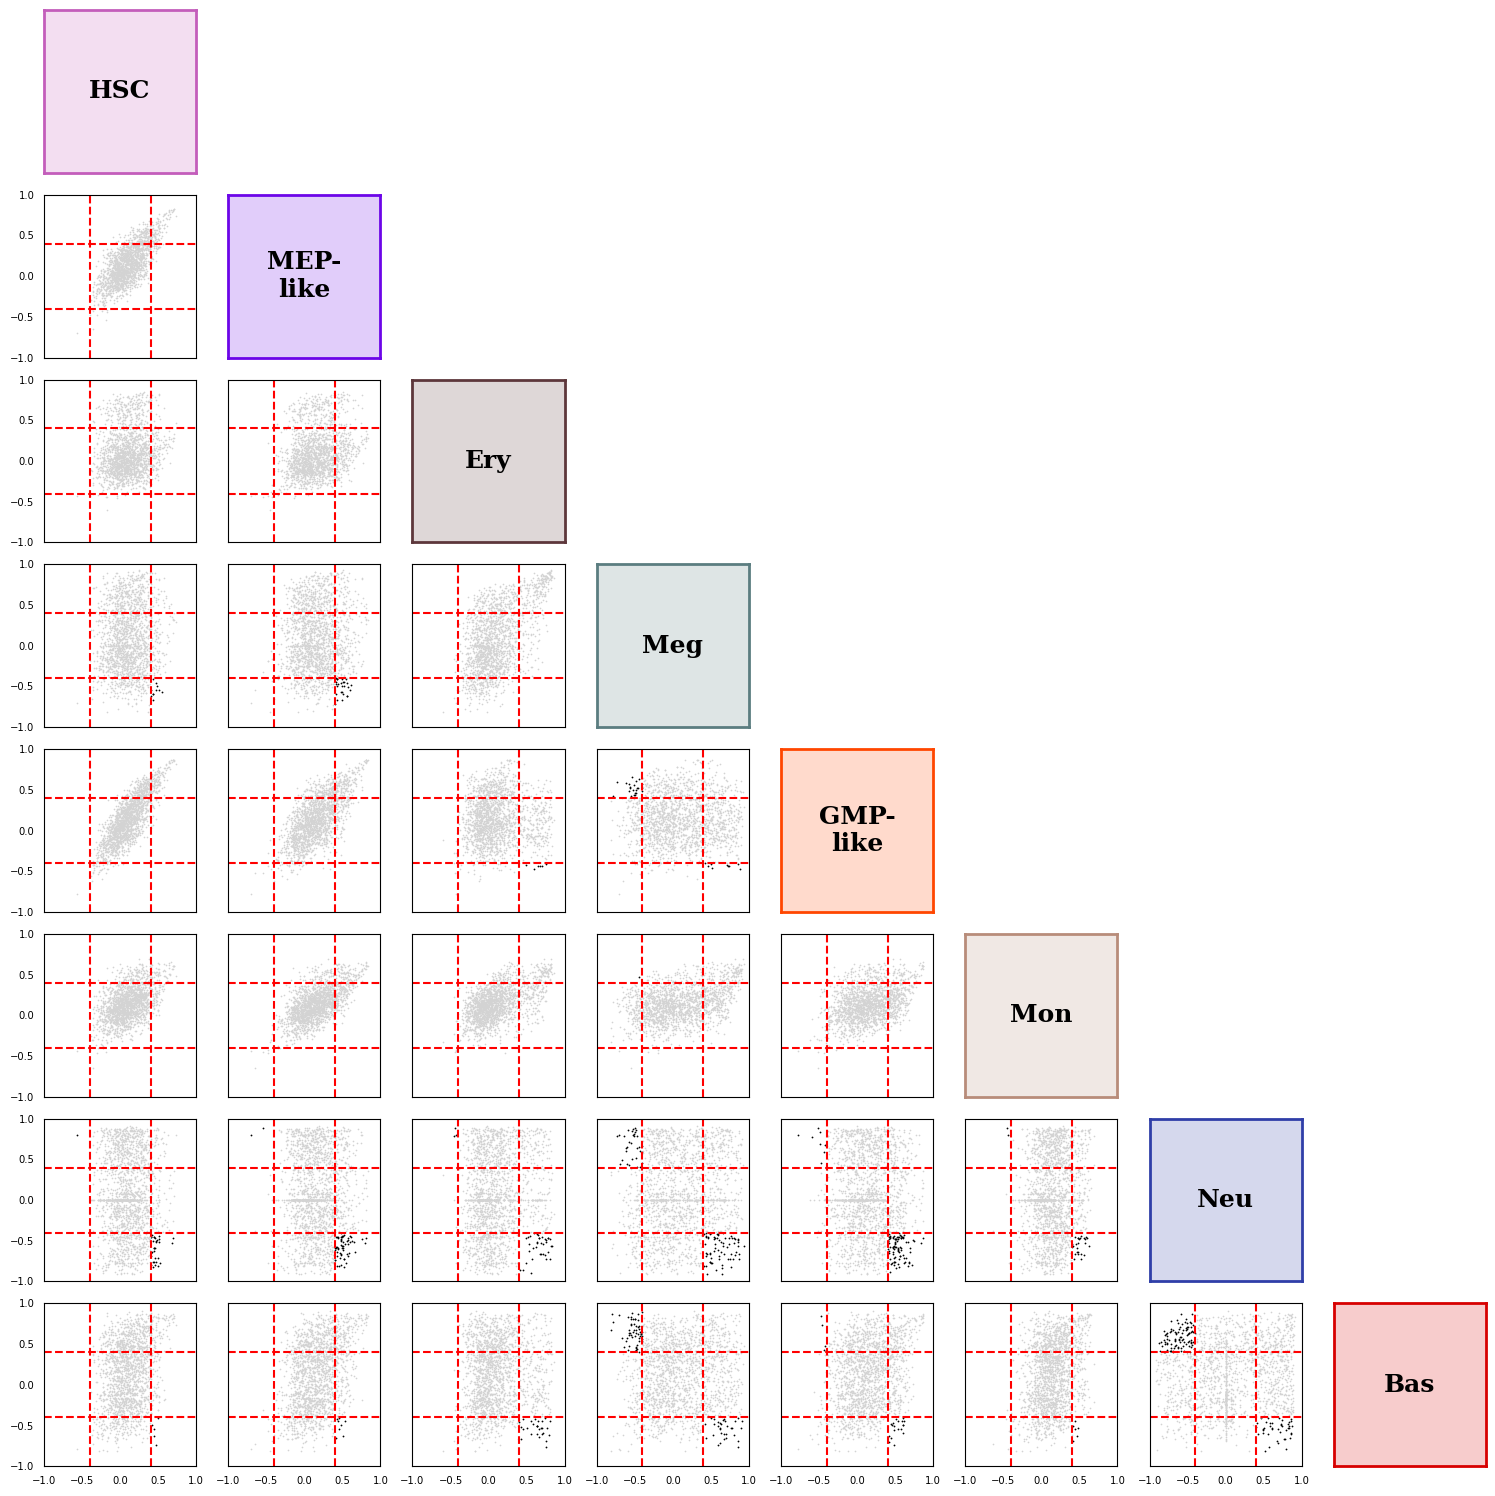

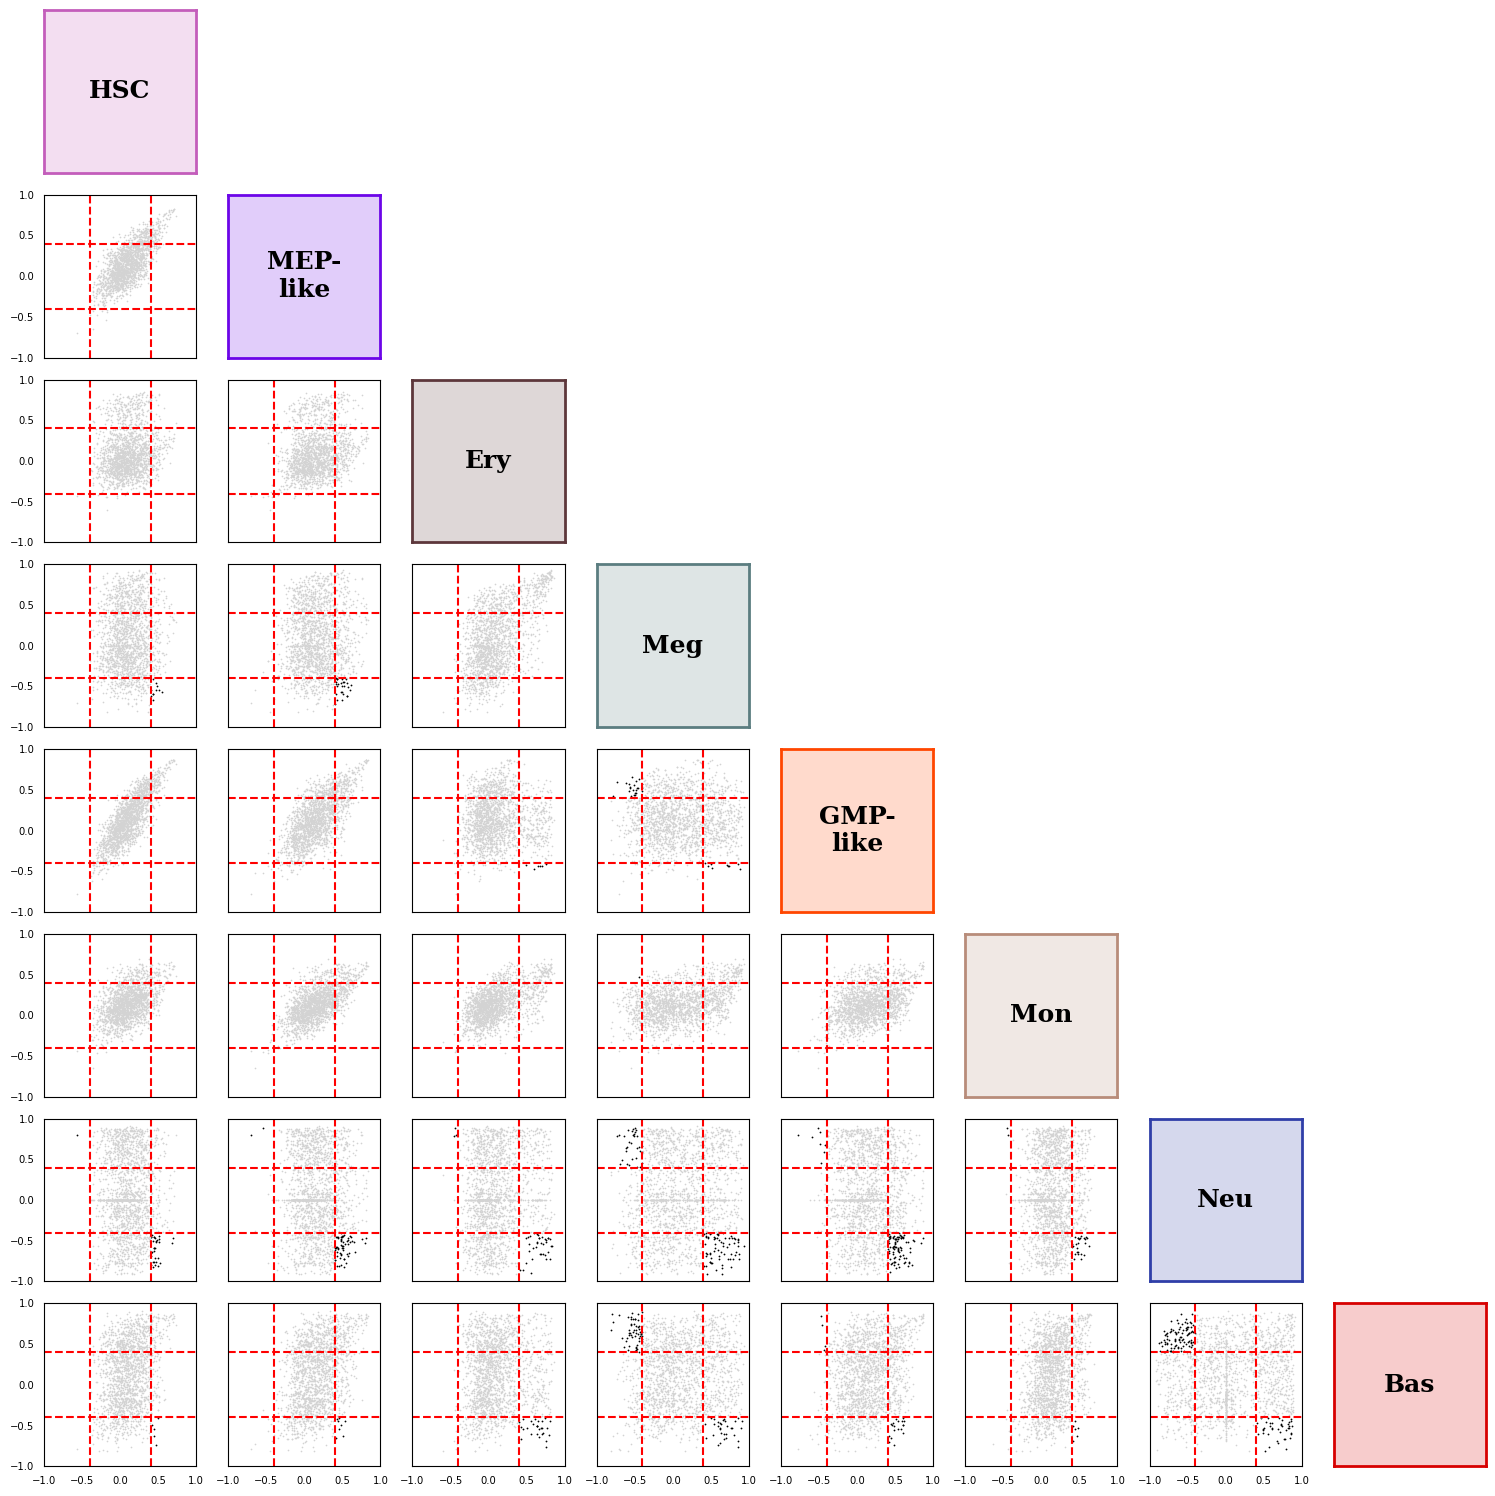

In [32]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='total',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

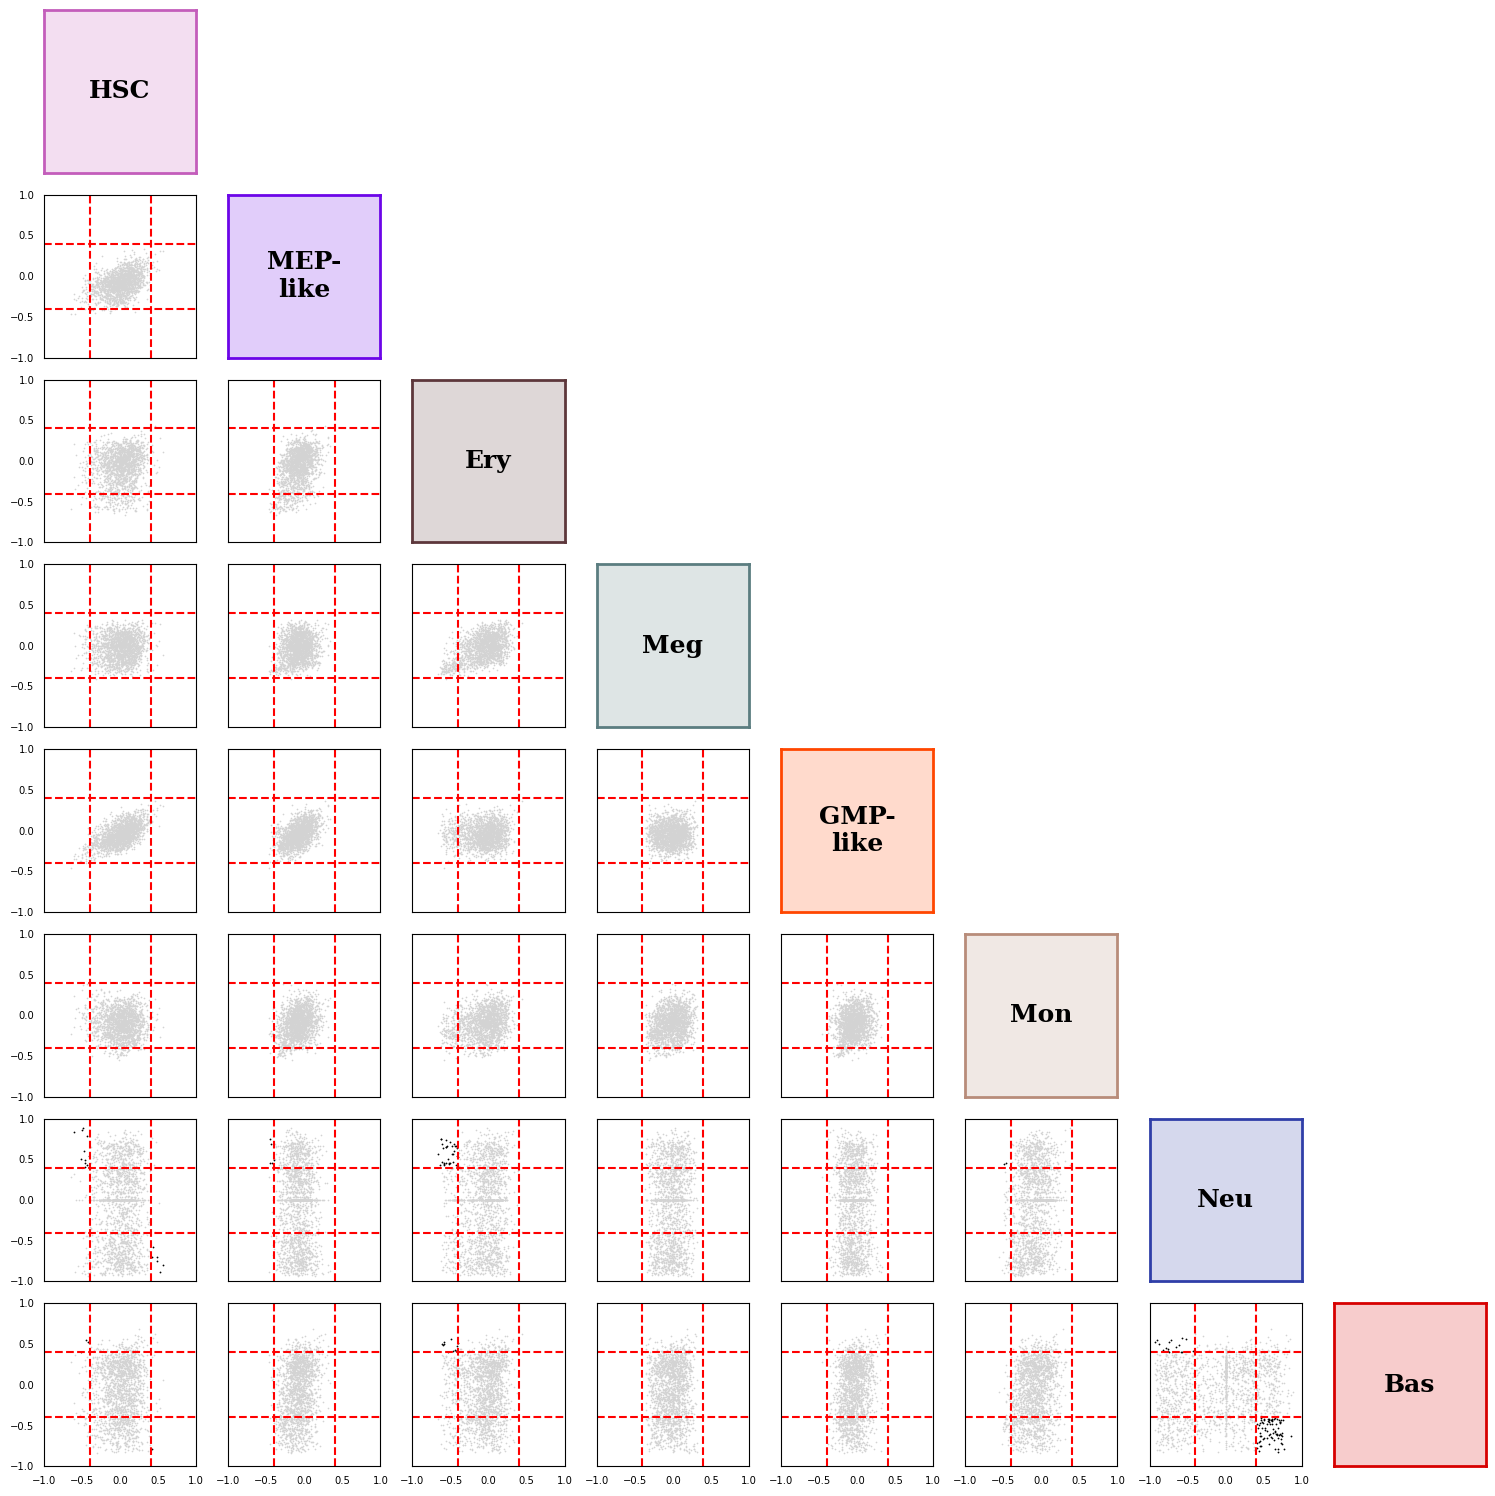

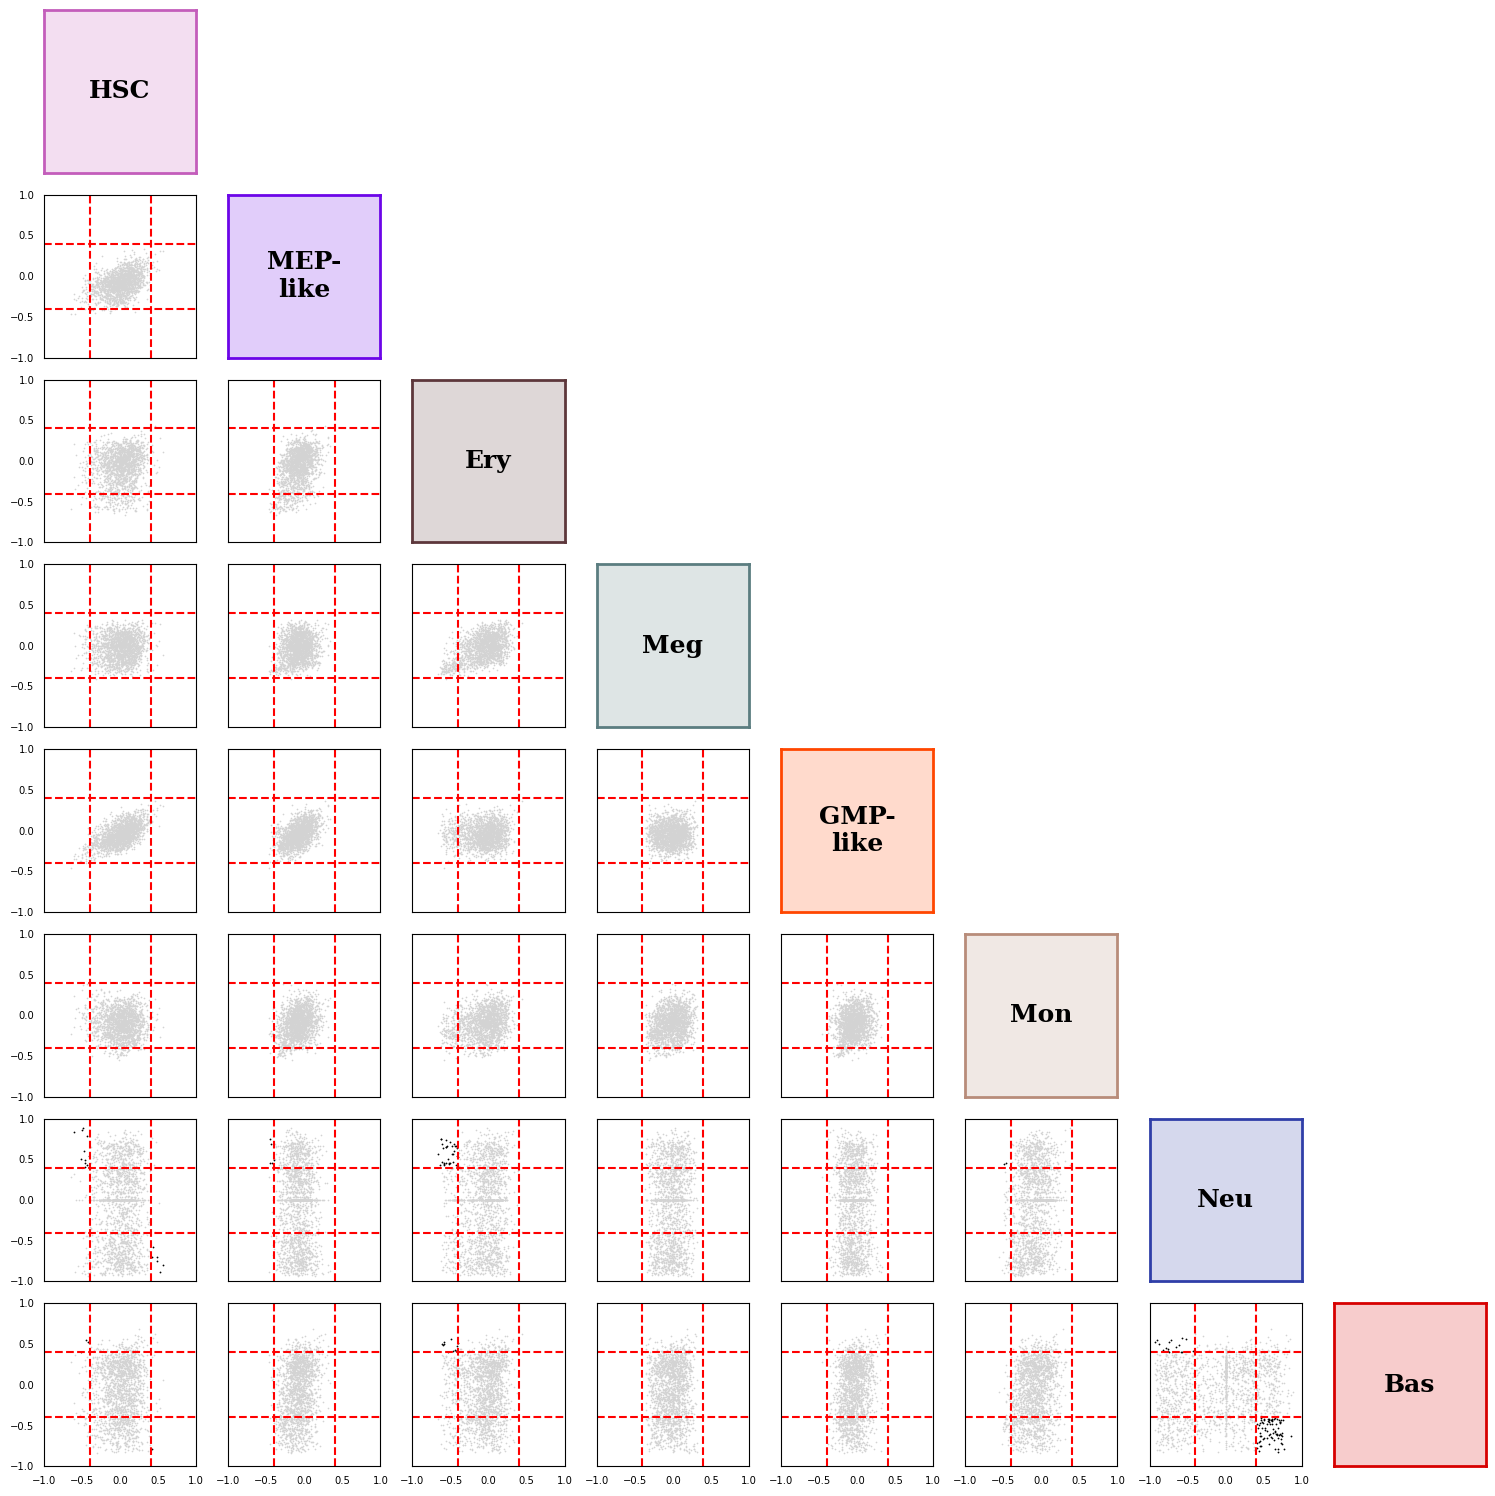

In [33]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='interaction',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

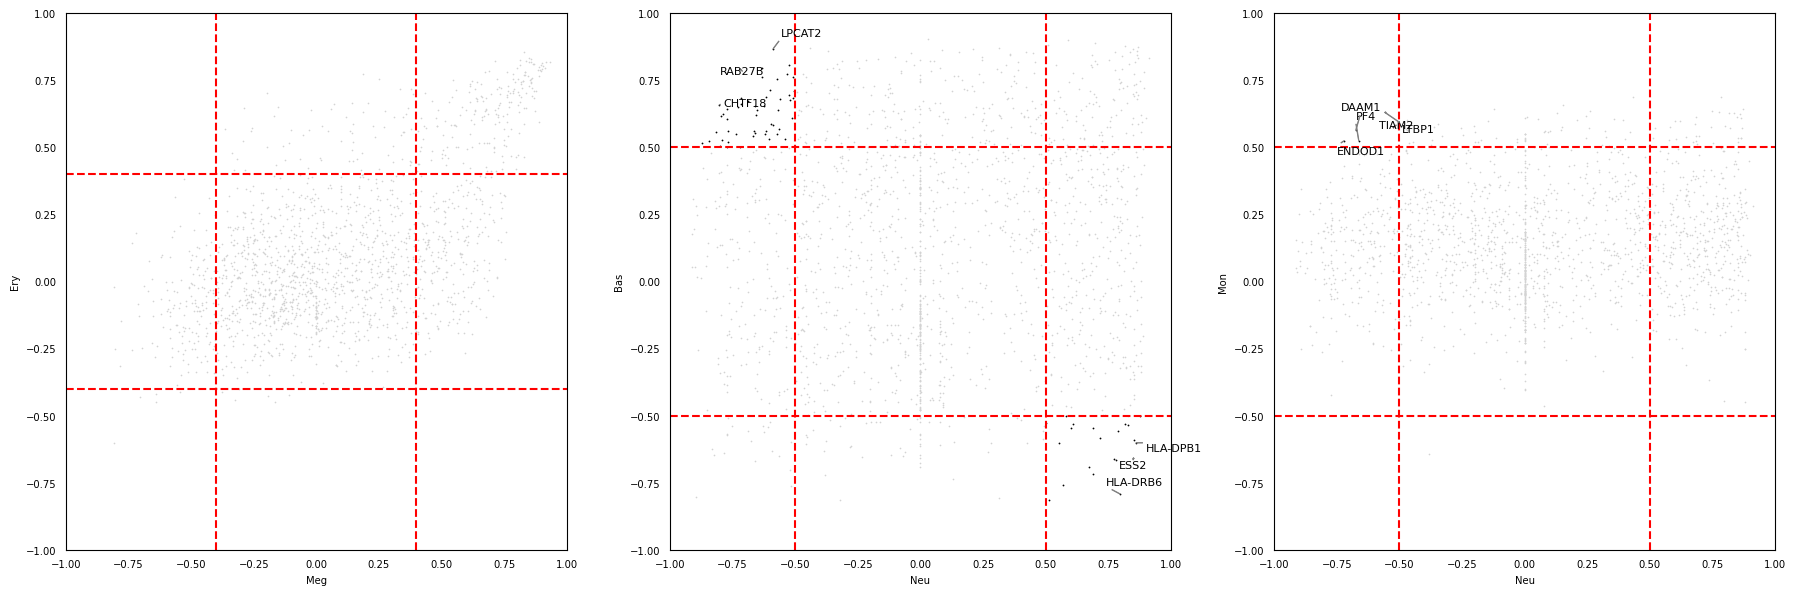

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)

sch.pl.plot_gene_correlation_scatter(adata, 'Meg', 'Ery', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[0], clus1_low=-0.4, clus1_high=0.4,
clus2_low=-0.4, clus2_high=0.4)
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Bas', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[1])
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Mon', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[2])

plt.show()


# Network scores

In [ ]:
The compute_network_centrality function you implemented is extremely slow. Before, I was using CellOracle Links object to do all this and it is much faster, probably
  because I run filter_links, but I am not sure. I will show you the Links class, and see if you an either improve the curretn function or just use CellOracle's as I
  was doing before

In [35]:
# ============================================================
# 1. Compute network centrality metrics
# ============================================================
# This replaces the Links object creation and network score calculation
sch.tl.compute_network_centrality(
    adata,
    cluster_key=CLUSTER_KEY,
    metrics=['degree_centrality', 'in_degree_centrality', 'out_degree_centrality',
            'betweenness_centrality', 'eigenvector_centrality', 'pagerank']
)

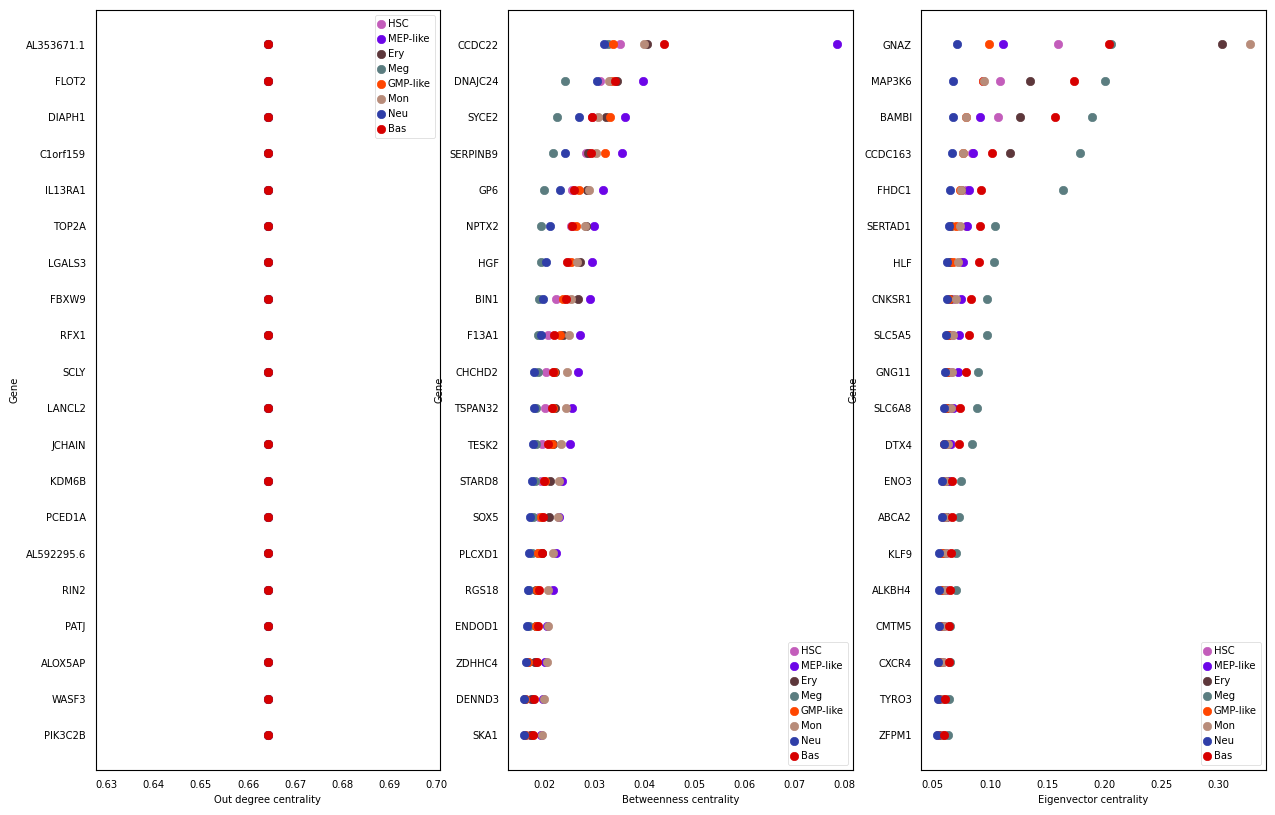

In [36]:
# ============================================================
# 2. Plot ranked genes by different centrality metrics
# ============================================================
# Create figure with multiple centrality rankings
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

metrics = ['out_degree_centrality', 'betweenness_centrality', 'eigenvector_centrality']
for ax, metric in zip(axes, metrics):
    sch.pl.plot_network_centrality_rank(
        adata,
        metric=metric,
        clusters=CELL_TYPE_ORDER,
        cluster_key=CLUSTER_KEY,
        n_genes=20,
        colors=colors,
        ax=ax
    )
plt.show()

In [37]:
# ============================================================
# 3. Get top genes tables for different metrics
# ============================================================
# Betweenness centrality table
df_betweenness = sch.tl.get_top_genes_table(
    adata,
    metric='betweenness_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_betweenness)

# Degree centrality table
df_degree = sch.tl.get_top_genes_table(
    adata,
    metric='out_degree_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_degree)

# Eigenvector centrality table
df_eigenvector = sch.tl.get_top_genes_table(
    adata,
    metric='eigenvector_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=10,
    order=CELL_TYPE_ORDER,
)
display(df_eigenvector)

# Get just the gene names (every other column)
genes_only = df_degree[[((cl, 'Gene')) for cl in CELL_TYPE_ORDER]]
display(genes_only)

HSC                         MEP-like                             Ery  \
        Gene Betweenness Centrality      Gene Betweenness Centrality     Gene   
0      TINF2               0.035184       A2M               0.078610   HIVEP1   
1     CAB39L               0.031117     THBS1               0.039688   SEMA4A   
2       RIN1               0.029460     CXCL3               0.036067  RPS6KA6   
3     PTP4A3               0.028397     CSRP1               0.035512  TRAPPC5   
4     SCPEP1               0.025468    MFSD10               0.031740    ITGAM   
5         F2               0.025358      CD33               0.029937     NKG7   
6      LOXL3               0.024965     RSPH1               0.029452    RAB3A   
7       ETV6               0.022321      CAV2               0.029134     ANO6   
8      HPGDS               0.020810     ISG15               0.027225    CPT1A   
9     KIF13B               0.020310      PBX1               0.026761    ERBB3   
10     TDRD7               0.020099    CAB39L               0.025541     PDP1   
11  TNFRSF1B               0.019495     LPAR2               0.025102    CKAP4   
12       SHD               0.019329     PDE5A               0.023453   GEMIN4   
13     ADCK5               0.018965     ITGB3               0.022876    GPNMB   
14     NAA40               0.018783      NAT9               0.022278    KCNK6   
15     MBNL3               0.018609      MCL1               0.021674      CBL   
16     DCLK2               0.018263      PRNP               0.020516   RPUSD1   
17    MAP3K5               0.018112    RPUSD1               0.020050    F2RL2   
18      RDM1               0.017304  TMEM229B               0.019717    RALYL   
19    TMEM79               0.017081      XKR8               0.019340  ARHGAP6   

                                Meg                         GMP-like  \
   Betweenness Centrality      Gene Betweenness Centrality      Gene   
0                0.040553   ALOX5AP               0.032645  SLC25A35   
1                0.034621   TNFSF14               0.024164   TRMT61A   
2                0.032357      SRA1               0.022426    PLXNA4   
3                0.028692   ABHD14A               0.021766      SOX4   
4                0.028493      SNX8               0.019995    PTGER3   
5                0.028361     CKAP4               0.019345     ISG15   
6                0.027087      ECI1               0.019321     EPHX2   
7                0.026808       ITK               0.018883      RILP   
8                0.023788     KCTD2               0.018794      ETV4   
9                0.022194     DCTN2               0.018621     ADCK5   
10               0.022136     TRIP4               0.018288      RGS6   
11               0.021800     PGBD5               0.018216    NDFIP2   
12               0.021191    CCDC22               0.018088     TUBA8   
13               0.020835     RAB31               0.017644      LRP2   
14               0.019600     AFAP1               0.017607      NCF2   
15               0.018285   CEACAM1               0.016924     RSPH1   
16               0.018216     TDRKH               0.016865  PRICKLE2   
17               0.018066     CASP7               0.016793     DCP1B   
18               0.017494      BMP6               0.016159    HSD3B7   
19               0.017364  CDC42EP4               0.016123   TRAPPC1   

                                Mon                              Neu  \
   Betweenness Centrality      Gene Betweenness Centrality      Gene   
0                0.033821    SLC6A8               0.040046   SLC44A2   
1                0.033264      LSP1               0.032862      DVL1   
2                0.033062  SLC25A19               0.030724      FLNA   
3                0.032153      PRTG               0.030421    SPRED1   
4                0.026980     EEF2K               0.028839       GSN   
5                0.026361     PPCDC               0.028137     PCDH7   
6                0.025347      LAX1               0.026429      S

HSC                          MEP-like                        \
          Gene Out Degree Centrality        Gene Out Degree Centrality   
0   AL353671.1              0.664157  AL353671.1              0.664157   
1        FLOT2              0.664157       FLOT2              0.664157   
2       DIAPH1              0.664157      DIAPH1              0.664157   
3     C1orf159              0.664157    C1orf159              0.664157   
4      IL13RA1              0.664157     IL13RA1              0.664157   
5        TOP2A              0.664157       TOP2A              0.664157   
6       LGALS3              0.664157      LGALS3              0.664157   
7        FBXW9              0.664157       FBXW9              0.664157   
8         RFX1              0.664157        RFX1              0.664157   
9         SCLY              0.664157        SCLY              0.664157   
10      LANCL2              0.664157      LANCL2              0.664157   
11      JCHAIN              0.664157      JCHAIN              0.664157   
12       KDM6B              0.664157       KDM6B              0.664157   
13      PCED1A              0.664157      PCED1A              0.664157   
14  AL592295.6              0.664157  AL592295.6              0.664157   
15        RIN2              0.664157        RIN2              0.664157   
16        PATJ              0.664157        PATJ              0.664157   
17     ALOX5AP              0.664157     ALOX5AP              0.664157   
18       WASF3              0.664157       WASF3              0.664157   
19     PIK3C2B              0.664157     PIK3C2B              0.664157   

           Ery                               Meg                        \
          Gene Out Degree Centrality        Gene Out Degree Centrality   
0   AL353671.1              0.664157  AL353671.1              0.664157   
1        FLOT2              0.664157       FLOT2              0.664157   
2       DIAPH1              0.664157      DIAPH1              0.664157   
3     C1orf159              0.664157    C1orf159              0.664157   
4      IL13RA1              0.664157     IL13RA1              0.664157   
5        TOP2A              0.664157       TOP2A              0.664157   
6       LGALS3              0.664157      LGALS3              0.664157   
7        FBXW9              0.664157       FBXW9              0.664157   
8         RFX1              0.664157        RFX1              0.664157   
9         SCLY              0.664157        SCLY              0.664157   
10      LANCL2              0.664157      LANCL2              0.664157   
11      JCHAIN              0.664157      JCHAIN              0.664157   
12       KDM6B              0.664157       KDM6B              0.664157   
13      PCED1A              0.664157      PCED1A              0.664157   
14  AL592295.6              0.664157  AL592295.6              0.664157   
15        RIN2              0.664157        RIN2              0.664157   
16        PATJ              0.664157        PATJ              0.664157   
17     ALOX5AP              0.664157     ALOX5AP              0.664157   
18       WASF3              0.664157       WASF3              0.664157   
19     PIK3C2B              0.664157     PIK3C2B              0.664157   

      GMP-like                               Mon                        \
          Gene Out Degree Centrality        Gene Out Degree Centrality   
0   AL353671.1              0.664157  AL353671.1              0.664157   
1        FLOT2              0.664157       FLOT2              0.664157   
2       DIAPH1              0.664157      DIAPH1              0.664157   
3     C1orf159              0.664157    C1orf159              0.664157   
4      IL13RA1              0.664157     IL13RA1              0.664157   
5        TOP2A              0.664157       TOP2A              0.664157   
6       LGALS3              0.664157      LGALS3              0.664157   
7        FBXW9              0.664157       FBXW9              0.664157   
8         RFX

HSC                        MEP-like                            Ery  \
      Gene Eigenvector Centrality     Gene Eigenvector Centrality    Gene   
0    THBS1               0.159077     SPEG               0.111044    SPEG   
1    F2RL2               0.108358    ITGB3               0.093846   SYNPO   
2     IER3               0.106998     AREG               0.091269    IL7R   
3  SERTAD1               0.084096    THBS1               0.084989     HLF   
4   RPUSD1               0.079130    TTC34               0.081892    AREG   
5    PGBD5               0.079121     GNAZ               0.080084   UBTD1   
6  PLEKHG3               0.074626    BAMBI               0.075930   TESK2   
7     CD40               0.067471      CD9               0.074523  POU6F1   
8    BAMBI               0.066726    SYNPO               0.073199  RASAL1   
9    EXTL3               0.066102  CCDC163               0.071892   RAB3A   

                               Meg                        GMP-like  \
  Eigenvector Centrality      Gene Eigenvector Centrality     Gene   
0               0.302826     UBTD1               0.206235    RSPH1   
1               0.135319      SPEG               0.200655     RILP   
2               0.126201      IER3               0.188941    BAMBI   
3               0.117067      CD48               0.178773    MMP14   
4               0.074356      LSP1               0.164226    THBS1   
5               0.065489  RNASEH2A               0.103922  CCDC163   
6               0.065343   TMEM205               0.103810    CMTM5   
7               0.064575     PLOD1               0.097454    IL21R   
8               0.063515     CEBPA               0.097057      SP2   
9               0.062716    CACNB4               0.089154     CD36   

                             Mon                             Neu  \
  Eigenvector Centrality    Gene Eigenvector Centrality     Gene   
0               0.098651   BAMBI               0.327333    ZFPM1   
1               0.094064  CCDC71               0.094732    CYHR1   
2               0.078889  HEXIM1               0.078762     RILP   
3               0.076491    SPEG               0.076740    TYRO3   
4               0.073441   CMTM5               0.074711   TRMT2A   
5               0.070028  SAMD14               0.073579  PLEKHA4   
6               0.067830   DAAM1               0.071930   SPATA1   
7               0.064258    GNAZ               0.070349     EVI5   
8               0.063415    HPGD               0.067510    SARM1   
9               0.062725    LMO4               0.066494  ASPSCR1   

                              Bas                         
  Eigenvector Centrality     Gene Eigenvector Centrality  
0               0.070801     GNAZ               0.204289  
1               0.067575   MAP3K6               0.173242  
2               0.067242    BAMBI               0.157222  
3               0.066458  CCDC163               0.101876  
4               0.064669    FHDC1               0.092218  
5               0.063792  SERTAD1               0.090921  
6               0.062652      HLF               0.090342  
7               0.062359   CNKSR1               0.083184  
8               0.061616   SLC5A5               0.081154  
9               0.060487    GNG11               0.079287

HSC    MEP-like         Ery         Meg    GMP-like         Mon  \
          Gene        Gene        Gene        Gene        Gene        Gene   
0   AL353671.1  AL353671.1  AL353671.1  AL353671.1  AL353671.1  AL353671.1   
1        FLOT2       FLOT2       FLOT2       FLOT2       FLOT2       FLOT2   
2       DIAPH1      DIAPH1      DIAPH1      DIAPH1      DIAPH1      DIAPH1   
3     C1orf159    C1orf159    C1orf159    C1orf159    C1orf159    C1orf159   
4      IL13RA1     IL13RA1     IL13RA1     IL13RA1     IL13RA1     IL13RA1   
5        TOP2A       TOP2A       TOP2A       TOP2A       TOP2A       TOP2A   
6       LGALS3      LGALS3      LGALS3      LGALS3      LGALS3      LGALS3   
7        FBXW9       FBXW9       FBXW9       FBXW9       FBXW9       FBXW9   
8         RFX1        RFX1        RFX1        RFX1        RFX1        RFX1   
9         SCLY        SCLY        SCLY        SCLY        SCLY        SCLY   
10      LANCL2      LANCL2      LANCL2      LANCL2      LANCL2      LANCL2   
11      JCHAIN      JCHAIN      JCHAIN      JCHAIN      JCHAIN      JCHAIN   
12       KDM6B       KDM6B       KDM6B       KDM6B       KDM6B       KDM6B   
13      PCED1A      PCED1A      PCED1A      PCED1A      PCED1A      PCED1A   
14  AL592295.6  AL592295.6  AL592295.6  AL592295.6  AL592295.6  AL592295.6   
15        RIN2        RIN2        RIN2        RIN2        RIN2        RIN2   
16        PATJ        PATJ        PATJ        PATJ        PATJ        PATJ   
17     ALOX5AP     ALOX5AP     ALOX5AP     ALOX5AP     ALOX5AP     ALOX5AP   
18       WASF3       WASF3       WASF3       WASF3       WASF3       WASF3   
19     PIK3C2B     PIK3C2B     PIK3C2B     PIK3C2B     PIK3C2B     PIK3C2B   

           Neu         Bas  
          Gene        Gene  
0   AL353671.1  AL353671.1  
1       DIAPH1       FLOT2  
2      IL13RA1      DIAPH1  
3        TOP2A    C1orf159  
4       LGALS3     IL13RA1  
5        FBXW9       TOP2A  
6         RFX1      LGALS3  
7         SCLY       FBXW9  
8       LANCL2        RFX1  
9       JCHAIN        SCLY  
10       KDM6B      LANCL2  
11       FLOT2      JCHAIN  
12      PCED1A       KDM6B  
13        RIN2      PCED1A  
14        PATJ  AL592295.6  
15     ALOX5AP        RIN2  
16       WASF3        PATJ  
17     PIK3C2B     ALOX5AP  
18       DSTYK       WASF3  
19       TMCC2     PIK3C2B

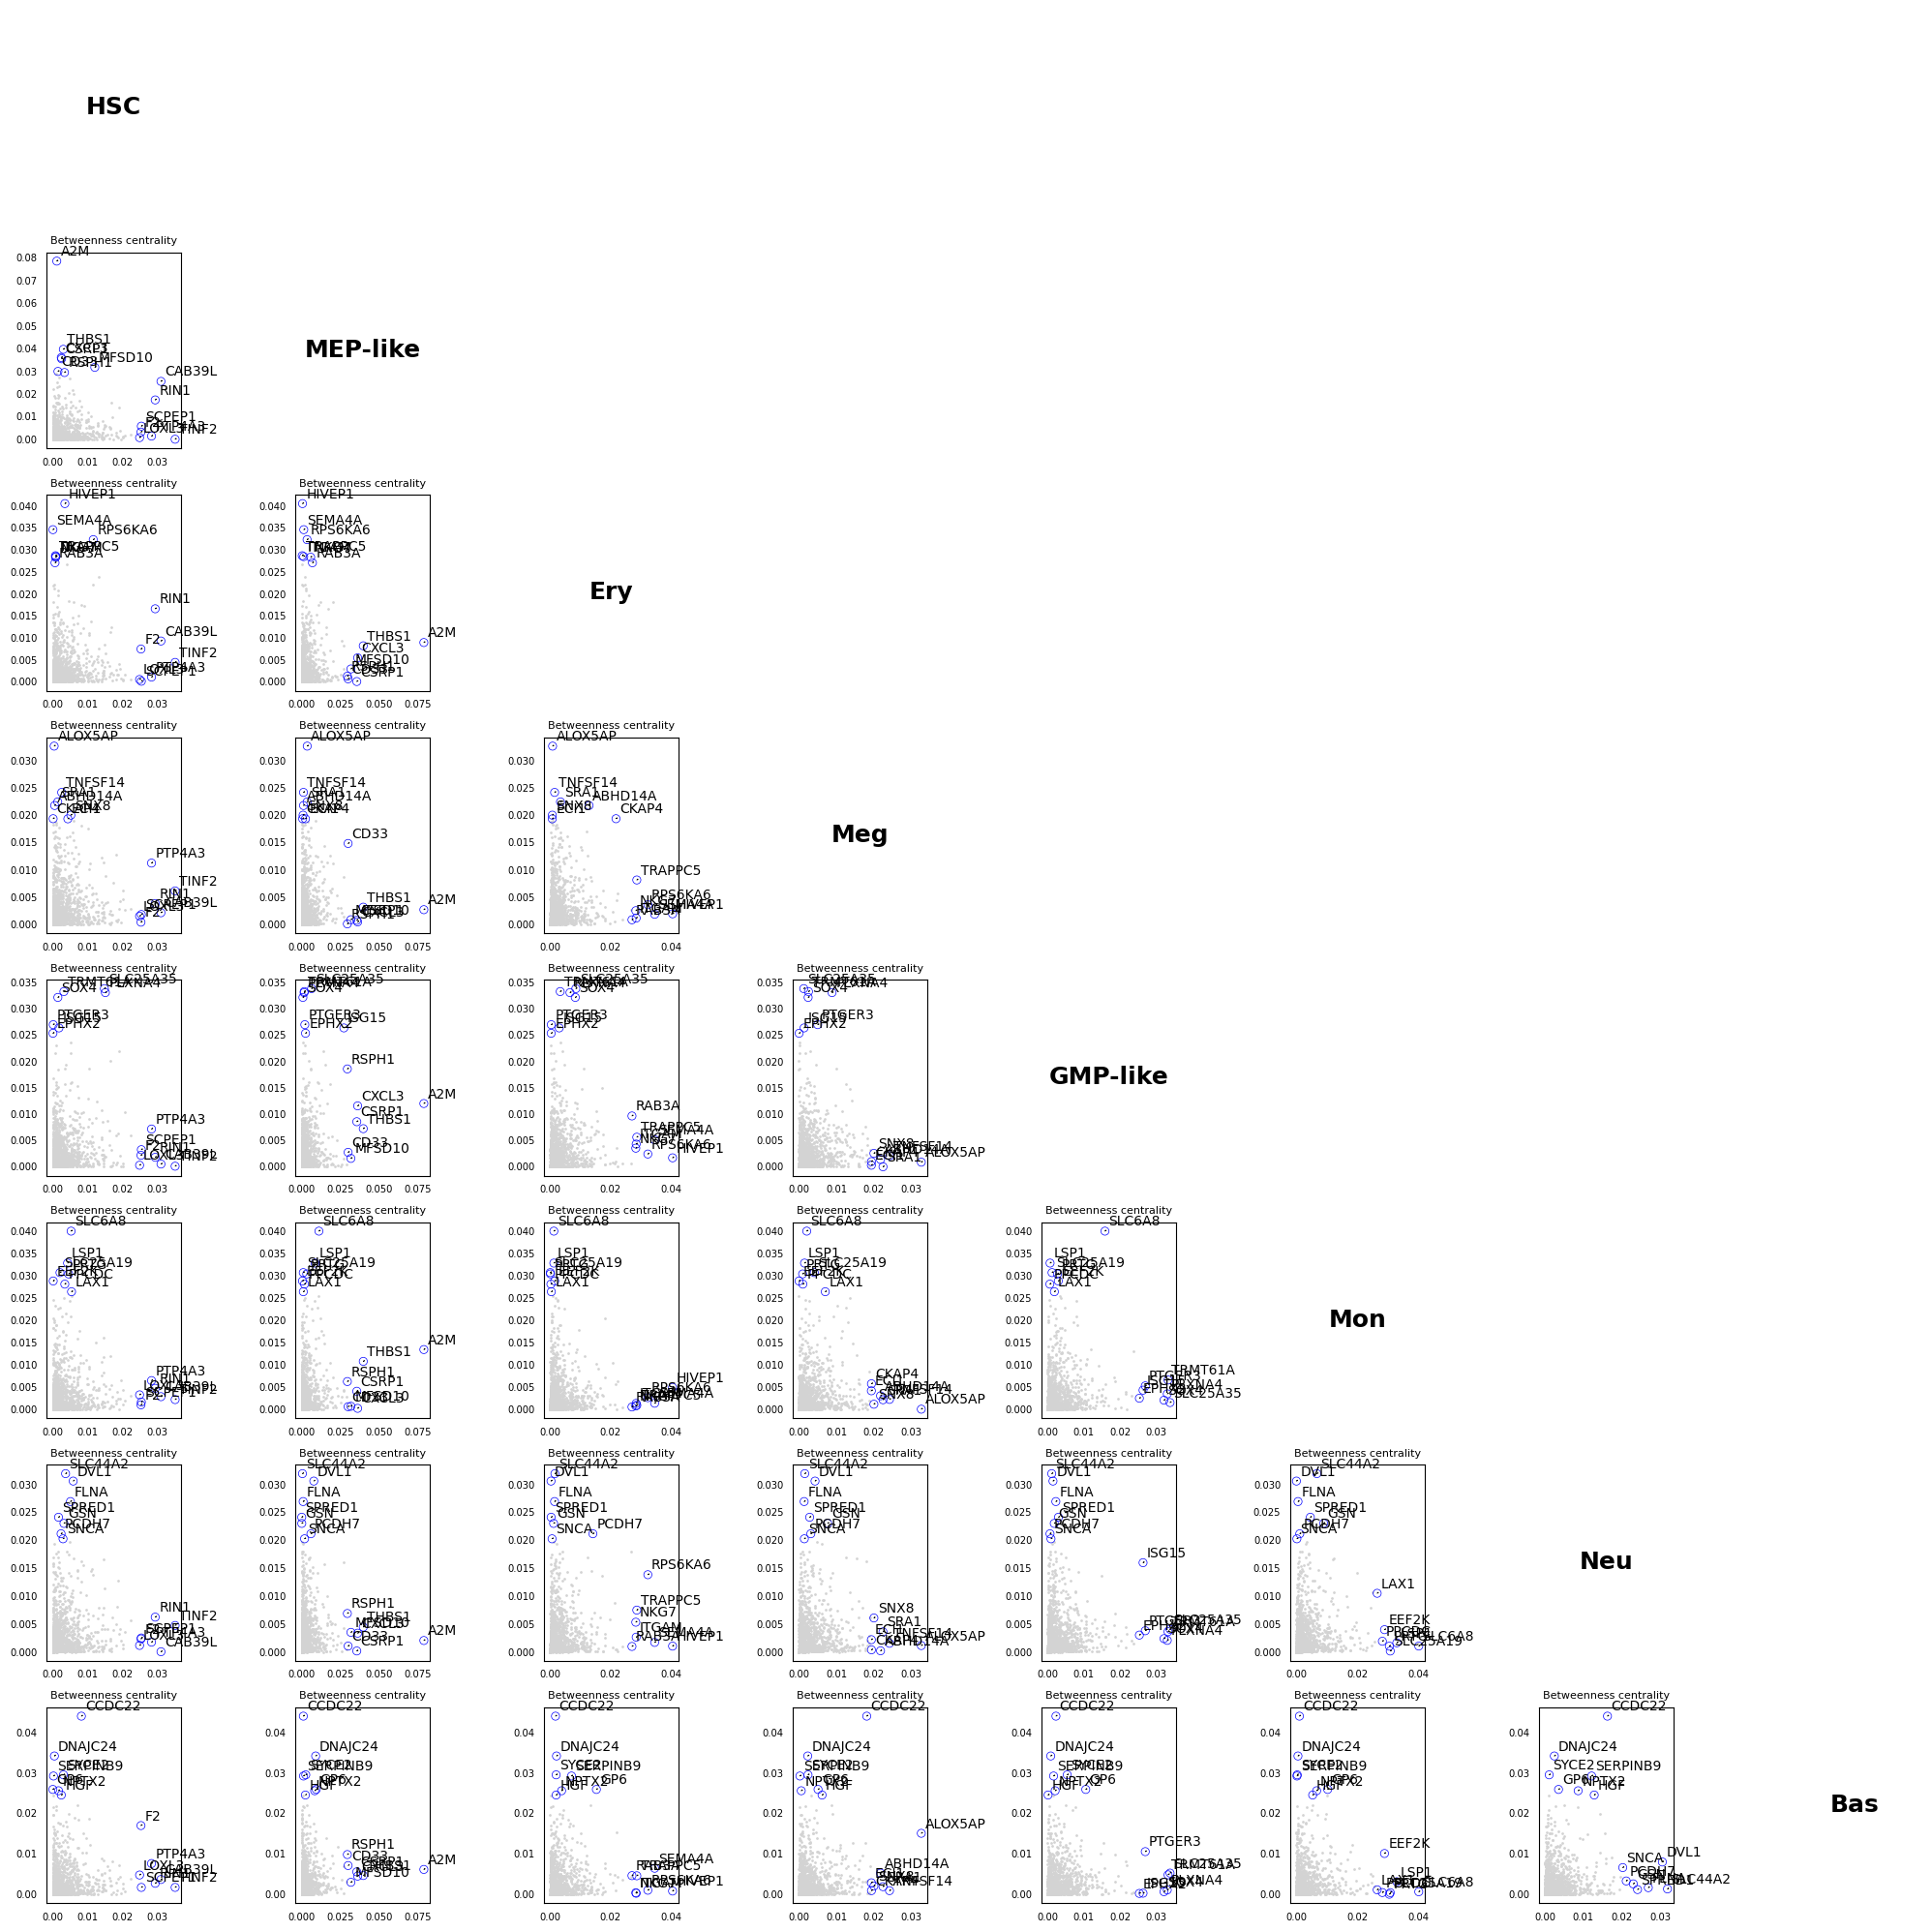

In [38]:
# ============================================================
# 4. Compare centrality between clusters (grid of comparisons)
# ============================================================
# This is similar to plot_score_comparison_grid but for one pair at a time
# You can create a grid manually or plot specific comparisons:
fig, axes = plt.subplots(len(CELL_TYPE_ORDER), len(CELL_TYPE_ORDER), figsize=(20, 20))

for i, clus1 in enumerate(CELL_TYPE_ORDER):
    for j, clus2 in enumerate(CELL_TYPE_ORDER):
        if i == j:
            # Diagonal: show cluster name
            axes[i, j].text(0.5, 0.5, clus1, ha='center', va='center',
                        fontsize=18, fontweight='bold',
                        transform=axes[i, j].transAxes)
            axes[i, j].axis('off')
        elif i < j:
            # Upper triangle: turn off
            axes[i, j].axis('off')
        else:
            # Lower triangle: plot comparison
            sch.pl.plot_centrality_comparison(
                adata,
                cluster1=CELL_TYPE_ORDER[j],
                cluster2=CELL_TYPE_ORDER[i],
                metric='betweenness_centrality',
                cluster_key=CLUSTER_KEY,
                percentile=99.6,
                annotate=True,
                ax=axes[i, j]
            )
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

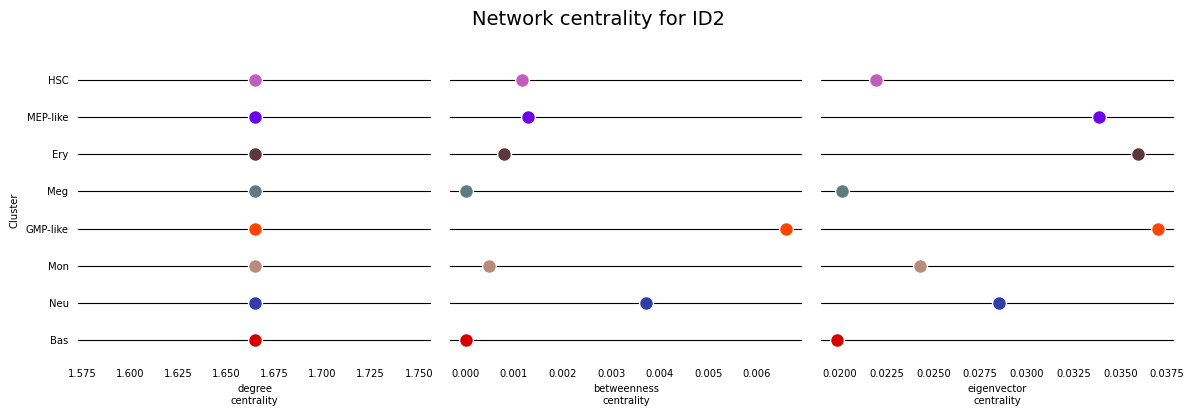

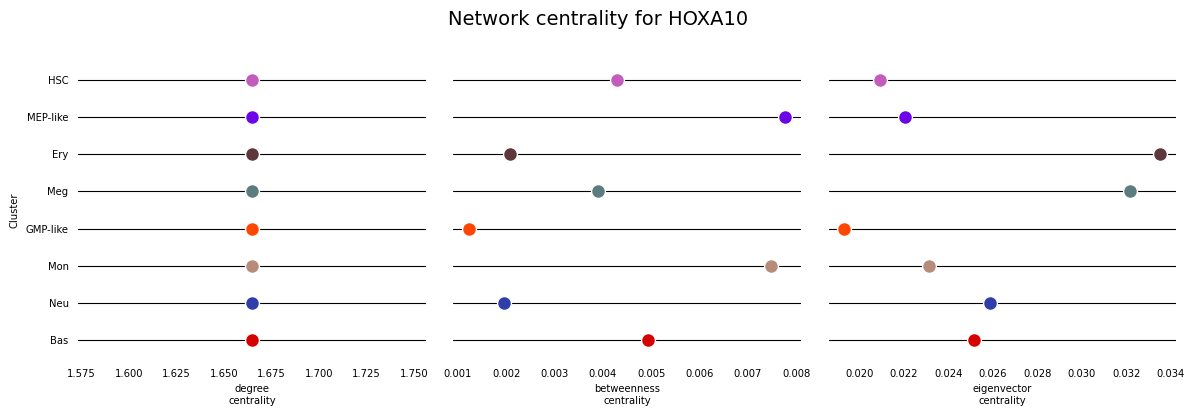

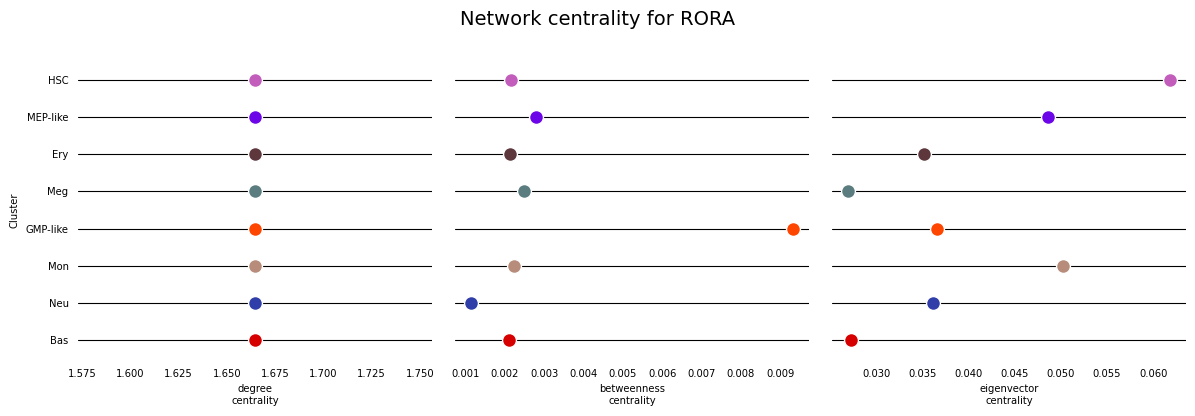

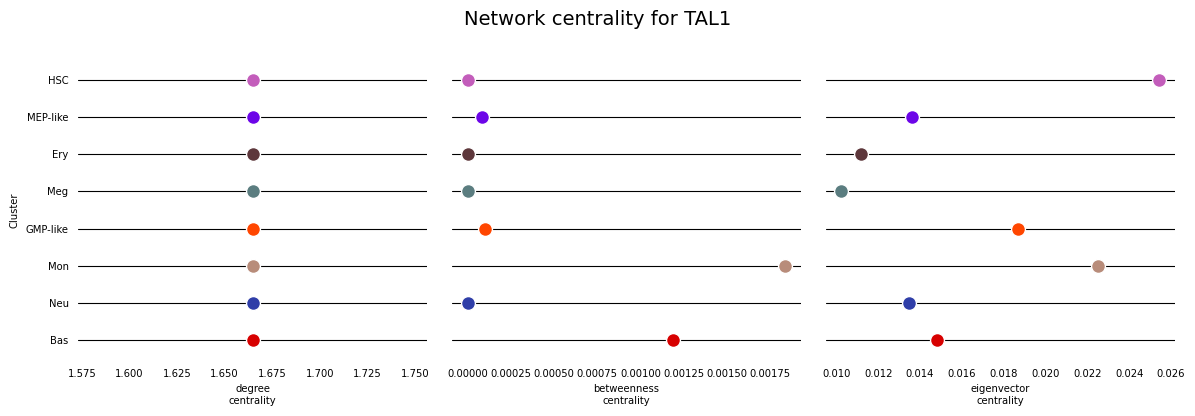

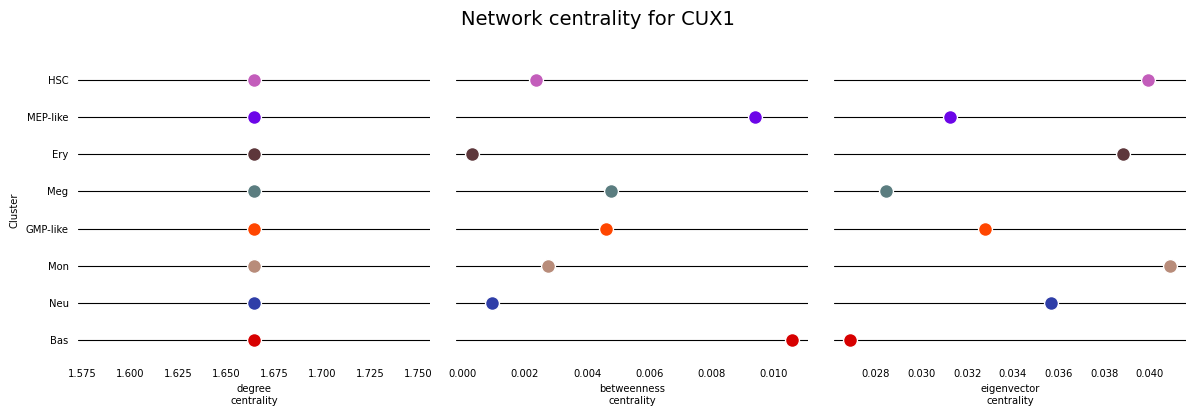

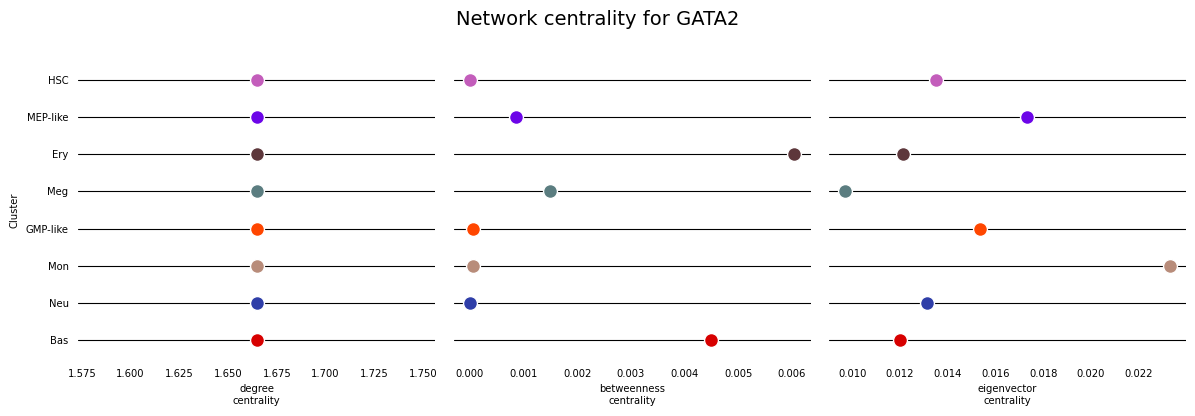

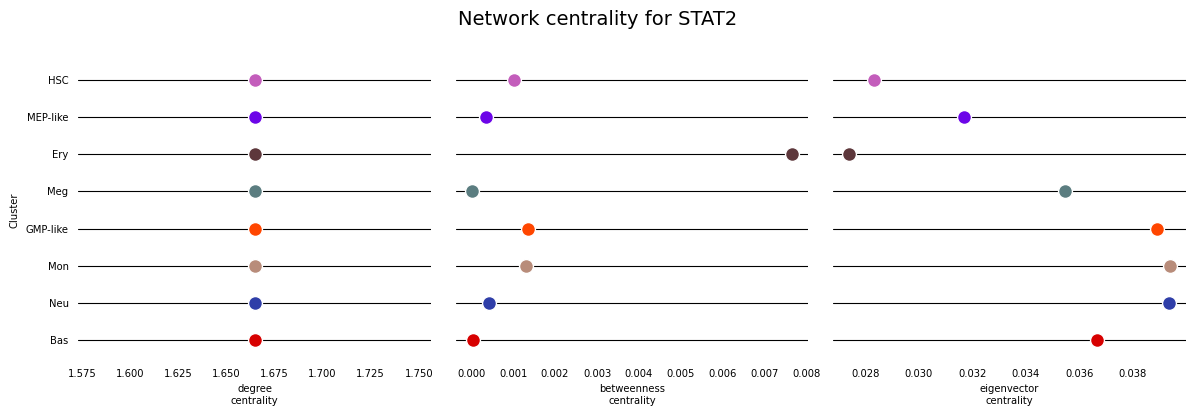

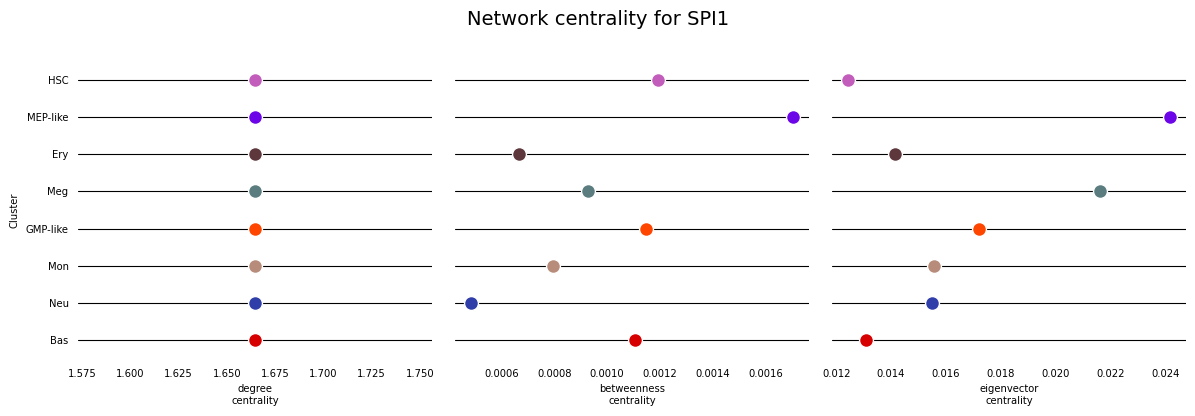

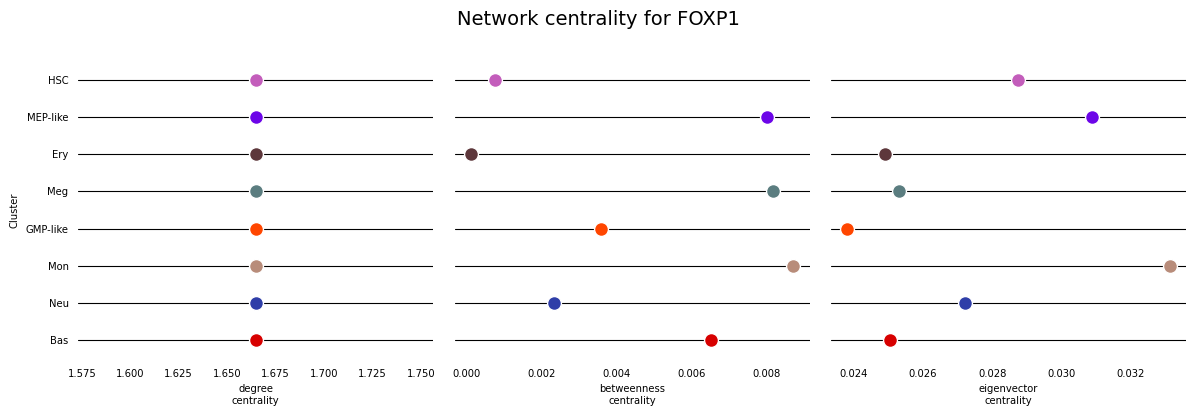

In [39]:
# ============================================================
# 5. Plot centrality for specific genes across clusters
# ============================================================
list_of_genes = ['ID2', 'HOXA10', 'RORA', 'TAL1', 'CUX1', 'GATA2',
                    'STAT2', 'SPI1', 'FOXP1']

for gene in list_of_genes:
    fig = sch.pl.plot_gene_centrality(
        adata,
        gene=gene,
        cluster_key=CLUSTER_KEY,
        order=CELL_TYPE_ORDER,
        colors=colors,
        figsize=(12, 4)
    )
    plt.show()

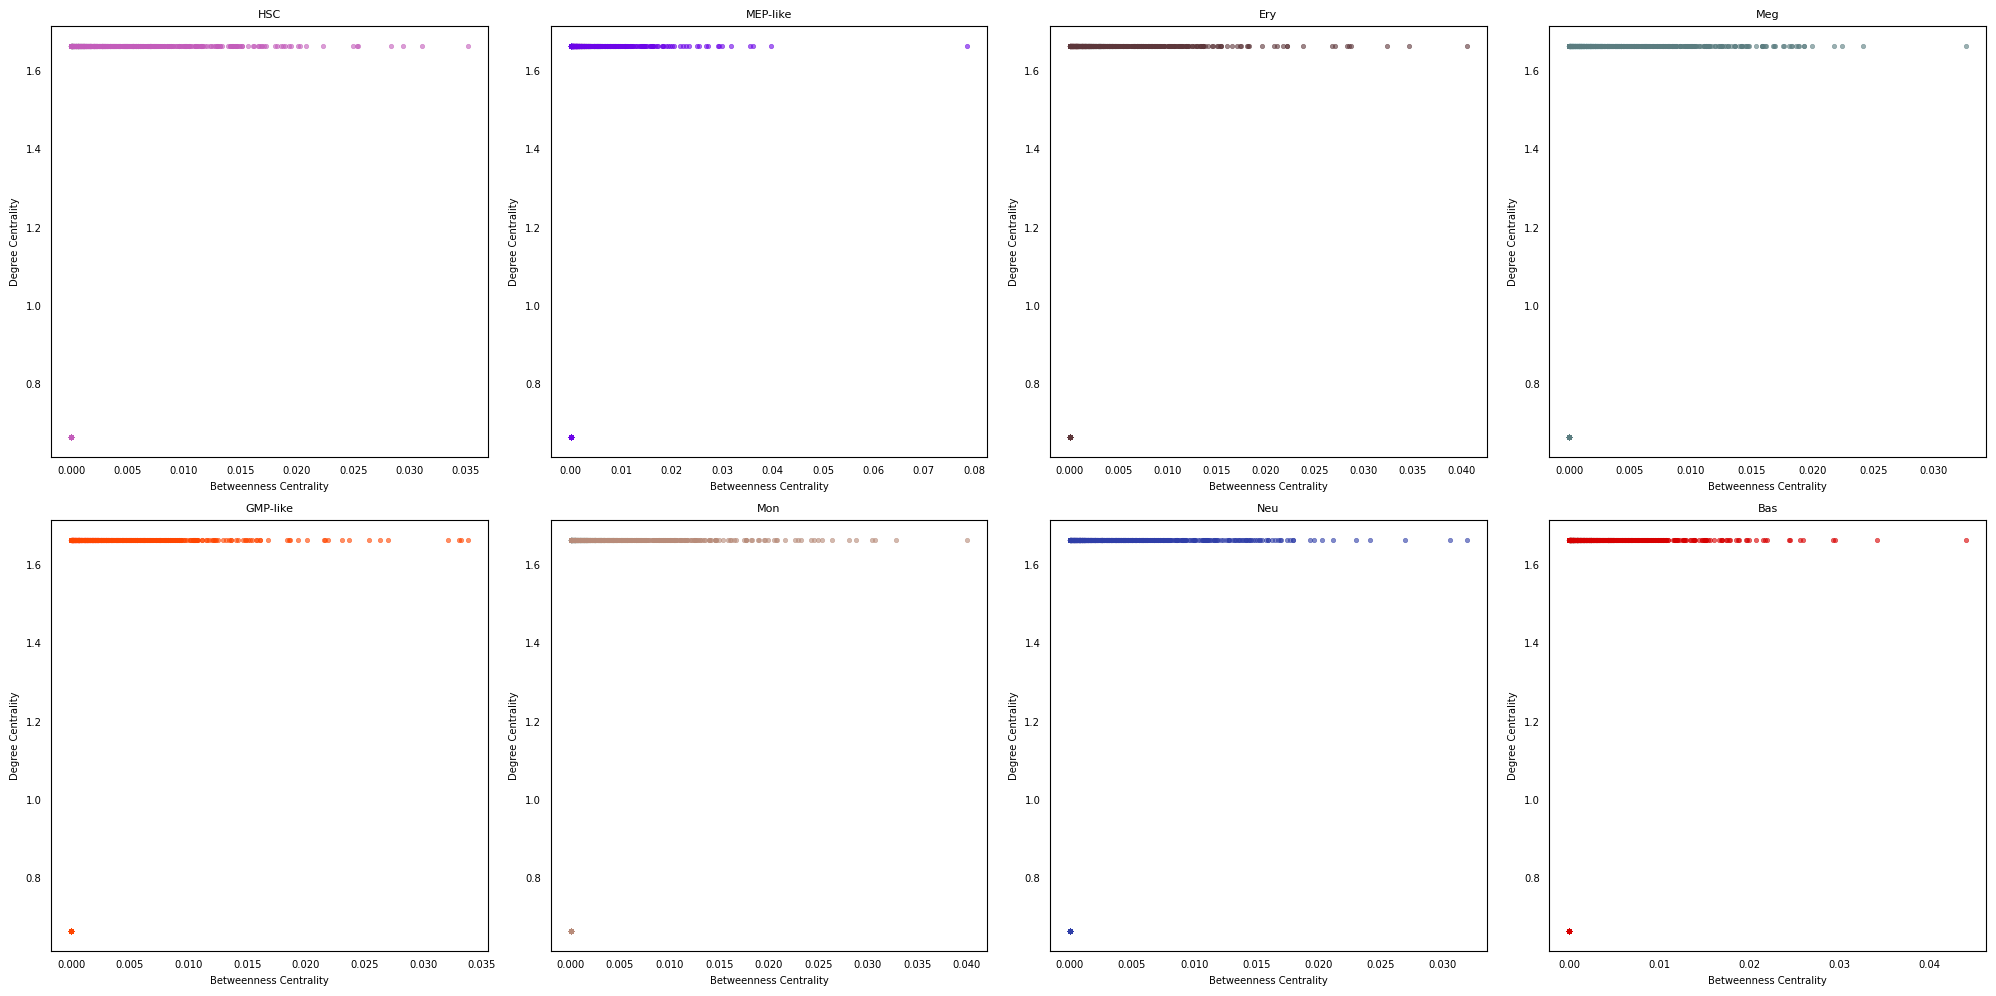

In [40]:
# ============================================================
# 6. Scatter plots: Betweenness vs Degree (high betweenness, low degree)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('degree_centrality', '<', 0.5),  # Find high betweenness with low degree
    figsize=(20, 10)
)
plt.show()

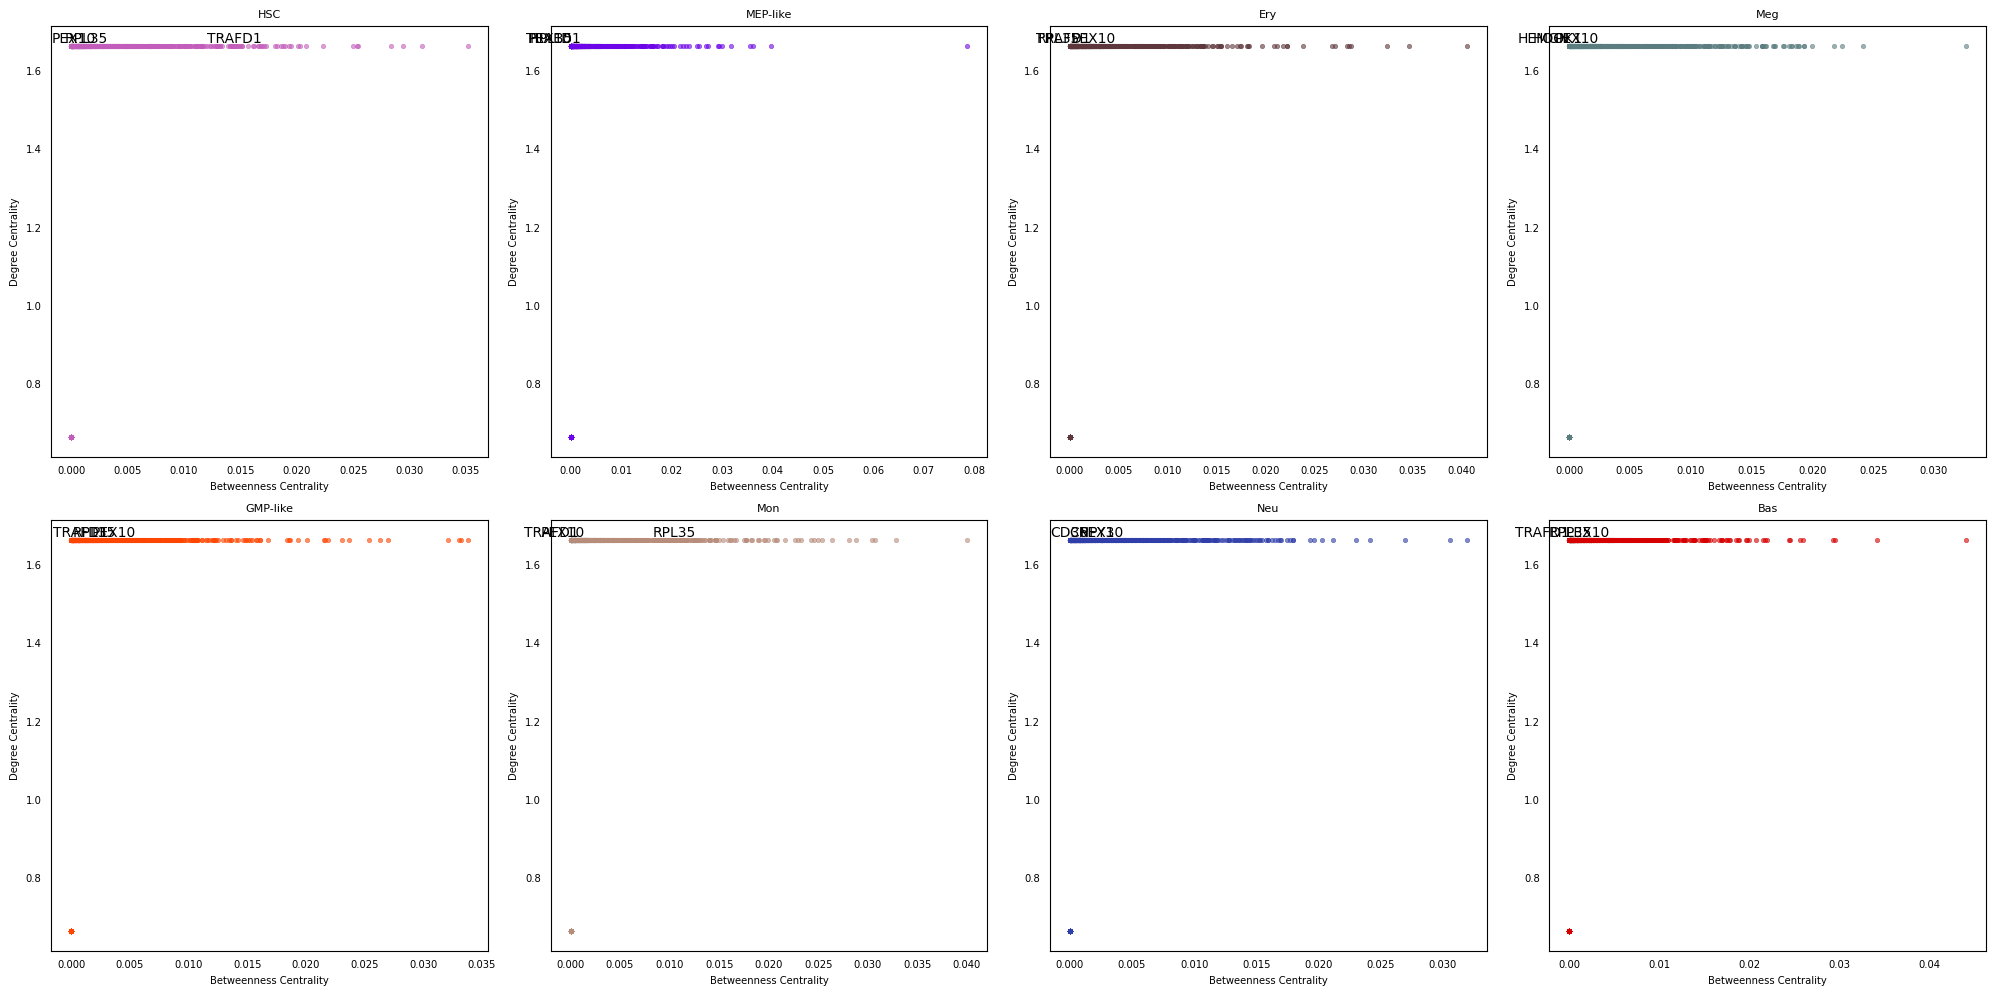

In [41]:
# ============================================================
# 7. Scatter plots: Betweenness vs Degree (high degree, low betweenness)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('betweenness_centrality', '<', 1000),  # Find high degree with low betweenness
    figsize=(20, 10)
)
plt.show()

# Eigenvalues

## Code

In [ ]:
e_vals = {}
e_vecs = {}
v_svd = {}
s2_svd = {}
ut_svd = {}

for i, cell_type in tqdm(enumerate(order)):
    e_vals[cell_type], e_vecs[cell_type] = np.linalg.eig(ls.W[cell_type])
    v_svd[cell_type], s2_svd[cell_type], ut_svd[cell_type] = np.linalg.svd(ls.W[cell_type])

## Check for the outlier eigenvalues and the corresponding eigenvectors, what genes are the predominant in the eigenvectors?
## Check also the genes with the highest negative real part of the eigenvalues
# Genes with the highest degradation energy per gene


8it [00:05,  1.47it/s]


In [ ]:
# Define constants and parameters
n_genes = 20
part = 'real'  # Can be 'real', 'imag', or 'abs'
exclude_genes = []
genes_in = np.where(~np.isin(ls.gene_names, exclude_genes))[0]

# Get the eigenvectors sorted by eigenvalues
df_rankings = pd.DataFrame(index=range(len(ls.gene_names)))

fig = plt.figure(figsize=(15, 64), tight_layout=True)
gs = fig.add_gridspec(16,4)
gene_axs = [[gs[i,j] for j in range(4)] for i in range(0,16,2)]
total_axs = [[gs[i,j:j+2] for j in range(0,4,2)] for i in range(1,16,2)]


for k,gene_ax,total_ax in zip(order,gene_axs,total_axs):
    eigenvalues = e_vals[k]
    eigenvectors = e_vecs[k][:, np.argsort(eigenvalues.real)[::-1]]
    for eig_n,ax in enumerate(gene_ax):
# Choose the part to plot (real, imaginary, or absolute value)
        parts = {
            'real': eigenvectors[:, eig_n].real,
            'imag': eigenvectors[:, eig_n].imag,
            'abs': np.abs(eigenvectors[:, eig_n])
        }
        vector_to_plot = parts[part][genes_in]

    # Create the plot
        sorted_indices = np.argsort(vector_to_plot)
        sorted_indices_absolute = np.argsort(np.abs(vector_to_plot))[::-1]
        indices_to_plot = sorted_indices_absolute[:n_genes]

        x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
        y_data = vector_to_plot[indices_to_plot]
        names = ls.gene_names[indices_to_plot]

        df_rankings[f'{k} {part} eigenvector {eig_n+1} genes'] = ls.gene_names[sorted_indices]
        df_rankings[f'{k} {part} eigenvector {eig_n+1}'] = vector_to_plot[sorted_indices]

                        
    for par,ax in zip(['real','imag'],total_ax):
        evecs = e_vecs[k].real if par=='real' else e_vecs[k].imag
        evals = e_vals[k].real if par=='real' else e_vals[k].imag

        e_score = evecs @ evals

        sorted_indices = np.argsort(e_score)
        sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
        indices_to_plot = sorted_indices_absolute[:n_genes]

        df_rankings[f'{k} {par} score genes'] = ls.gene_names[sorted_indices]
        df_rankings[f'{k} {par} score'] = e_score[sorted_indices]

        x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
        y_data = e_score[indices_to_plot]
        names = ls.gene_names[indices_to_plot]


In [ ]:
def linspace_iterator(start, stop, num):
    if num == 1:
        yield start
        return
    step = (stop - start) / float(num - 1)
    for i in range(num):
        yield start + i * step

def annotate_points(ax, x_data, y_data, labels, offset_x_fraction=0.1, offset_y_fraction=0.1):
    n_positive = sum(y >= 0 for y in y_data)
    n_negative = sum(y < 0 for y in y_data)
    n_total = len(y_data) // 2
    frac_positive = n_positive / n_total
    frac_negative = n_negative / n_total
    offsets_positive = linspace_iterator(-0.25 * offset_y_fraction * frac_positive, 1.75 * offset_y_fraction * frac_positive, n_positive)
    offsets_negative = linspace_iterator(-0.25 * offset_y_fraction * frac_negative, 1.75 * offset_y_fraction * frac_negative, n_negative)
    offset_x = offset_x_fraction

    for name, x, y in zip(labels, x_data, y_data):
        offset_y = next(offsets_positive) if y >= 0 else next(offsets_negative)

        # Convert offset to display coordinates
        offset_x_data = offset_x * ax.figure.dpi
        offset_y_data = offset_y * ax.figure.dpi

        # Determine text position based on y-value
        if y < 0:
            xytext = (offset_x_data, offset_y_data)
            ha = 'left'
        else:
            xytext = (-offset_x_data, -offset_y_data)
            ha = 'right'

        # Annotate the point
        ax.annotate(name, xy=(x, y), xytext=xytext, fontsize=8, ha=ha, textcoords='offset points', 
                    arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

# Define constants and parameters
n_genes = 10
n_genes_table = 100
part = 'real'  # Can be 'real', 'imag', or 'abs'
exclude_genes = []
genes_in = np.where(~np.isin(ls.gene_names, exclude_genes))[0]


## Figure

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(15, 3 * len(order)))
df_eigenvalues = pd.DataFrame(index=range(1,n_genes_table+1),columns=pd.MultiIndex.from_product([order, ['EV gene', 'EV value', 'Score gene', 'Score value']]))
top_evalues = {}

n_gernes = 10

for i, cell_type in enumerate(order):
    # Calculate eigenvalues and eigenvectors
    e_vals, e_vecs = np.linalg.eig(ls.W[cell_type])
    
    # Plot eigenvalues (real vs imaginary)
    ax = axs[i, 0]
    ax.scatter(e_vals.real, e_vals.imag, label=cell_type, color=colors[cell_type])
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend()
    if i == 0:
        ax.set_title(f'Eigenvalues')

    # Plot sorted eigenvector components
    eigenvector = e_vecs[:, np.argmax(e_vals.real)]
    top_evalues[cell_type] = e_vals[np.argmax(e_vals.real)]
    sorted_indices_abs = np.argsort(np.abs(eigenvector))[::-1]
    sorted_indices = np.argsort(eigenvector)
    indices_for_table = sorted_indices_abs[:n_genes_table]
    indices_to_plot = sorted_indices_abs[:n_genes]
    
    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = eigenvector[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues[cell_type, 'EV gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues[cell_type, 'EV value'] = list(map(lambda x: f'{np.real(x):.3f}', eigenvector[indices_for_table]))
    
    ax = axs[i, 1]
    ax.plot(eigenvector[sorted_indices], '.', color=colors[cell_type])
    ax.set_ylabel('Component value')
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    ax.set_xticks([])
    if i == 0:
        ax.set_title(f'First Eigenvector components')

    # Plot real eigenvector score sorted
    evecs = e_vecs.real if part=='real' else e_vecs.imag
    evals = e_vals.real if part=='real' else e_vals.imag

    e_score = evecs @ evals

    sorted_indices = np.argsort(e_score)
    sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
    indices_to_plot = sorted_indices_absolute[:n_genes]
    indices_for_table = sorted_indices_abs[:n_genes_table]

    df_rankings[f'{cell_type} {part} score genes'] = ls.gene_names[sorted_indices]
    df_rankings[f'{cell_type} {part} score'] = e_score[sorted_indices]

    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = e_score[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues[cell_type, 'Score gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues[cell_type, 'Score value'] = list(map(lambda x: f'{np.real(x):.3f}', e_score[indices_for_table]))

    ax = axs[i, 2]
    ax.plot(np.sort(e_score),'.',color=colors[cell_type])
    ax.set_ylabel('Component score')
    ax.set_xticks([])
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    if i == 0:
        ax.set_title(f'Eigenvector score')


# fig.savefig('../../FiguresForPaper/Eigenvectors.pdf')
plt.tight_layout()
plt.show()


In [ ]:
df = df_eigenvalues.loc[:, pd.MultiIndex.from_product([order, ['EV gene', 'EV value']])]

# Initialize an empty DataFrame to store sorted values
sorted_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each cluster (every 2 columns: "EV gene" and "EV value")
for cluster in df.columns.levels[0]:  # Get unique cluster names
    ev_gene_col = (cluster, "EV gene")   # Tuple for MultiIndex
    ev_value_col = (cluster, "EV value") # Tuple for MultiIndex
    
    # Sort by absolute value of EV value
    sorted_cluster = df.sort_values(by=ev_value_col, key=lambda x: abs(x.astype('float')), ascending=False)
    
    # Store the sorted results
    sorted_df[ev_gene_col] = sorted_cluster[ev_gene_col].values
    sorted_df[ev_value_col] = sorted_cluster[ev_value_col].values

# Reset index to match original
sorted_df.reset_index(drop=True, inplace=True)

print(top_evalues)

# Display the sorted DataFrame
sorted_df.head(10)

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(15, 3 * len(order)))
df_eigenvalues_neg = pd.DataFrame(index=range(1,n_genes_table+1),columns=pd.MultiIndex.from_product([order, ['EV gene', 'EV value', 'Score gene', 'Score value']]))
top_neg_evalues = {}

n_genes = 10
for i, cell_type in tqdm(enumerate(order)):
    # Calculate eigenvalues and eigenvectors
    e_vals, e_vecs = np.linalg.eig(ls.W[cell_type])
    
    # Plot eigenvalues (real vs imaginary)
    ax = axs[i, 0]
    ax.scatter(e_vals.real, e_vals.imag, label=cell_type, color=colors[cell_type])
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend()
    if i == 0:
        ax.set_title(f'Eigenvalues')

    # Plot sorted eigenvector components
    eigenvector = e_vecs[:, np.argmin(e_vals.real)]
    top_neg_evalues[cell_type] = e_vals[np.argmin(e_vals.real)]
    sorted_indices_abs = np.argsort(np.abs(eigenvector))[::-1]
    sorted_indices = np.argsort(eigenvector)
    indices_for_table = sorted_indices_abs[:n_genes_table]
    indices_to_plot = sorted_indices_abs[:n_genes]
    
    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = eigenvector[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues_neg[cell_type, 'EV gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues_neg[cell_type, 'EV value'] = list(map(lambda x: f'{np.real(x):.3f}', eigenvector[indices_for_table]))
    
    ax = axs[i, 1]
    ax.plot(eigenvector[sorted_indices], '.', color=colors[cell_type])
    ax.set_ylabel('Component value')
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    ax.set_xticks([])
    if i == 0:
        ax.set_title(f'First Eigenvector components')

    # Plot real eigenvector score sorted
    evecs = e_vecs.real if part=='real' else e_vecs.imag
    evals = e_vals.real if part=='real' else e_vals.imag

    e_score = evecs @ evals

    sorted_indices = np.argsort(e_score)
    sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
    indices_to_plot = sorted_indices_absolute[:n_genes]
    indices_for_table = sorted_indices_abs[:n_genes_table]

    df_rankings[f'{cell_type} {part} score genes'] = ls.gene_names[sorted_indices]
    df_rankings[f'{cell_type} {part} score'] = e_score[sorted_indices]

    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = e_score[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues_neg[cell_type, 'Score gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues_neg[cell_type, 'Score value'] = list(map(lambda x: f'{np.real(x):.3f}', e_score[indices_for_table]))

    ax = axs[i, 2]
    ax.plot(np.sort(e_score),'.',color=colors[cell_type])
    ax.set_ylabel('Component score')
    ax.set_xticks([])
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    if i == 0:
        ax.set_title(f'Eigenvector score')


# fig.savefig('../../FiguresForPaper/Eigenvectors.pdf')
plt.tight_layout()
plt.show()


In [ ]:
df = df_eigenvalues_neg.loc[:, pd.MultiIndex.from_product([order, ['EV gene', 'EV value']])]

# Initialize an empty DataFrame to store sorted values
sorted_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each cluster (every 2 columns: "EV gene" and "EV value")
for cluster in df.columns.levels[0]:  # Get unique cluster names
    ev_gene_col = (cluster, "EV gene")   # Tuple for MultiIndex
    ev_value_col = (cluster, "EV value") # Tuple for MultiIndex
    
    # Sort by absolute value of EV value
    sorted_cluster = df.sort_values(by=ev_value_col, key=lambda x: abs(x.astype('float')), ascending=False)
    
    # Store the sorted results
    sorted_df[ev_gene_col] = sorted_cluster[ev_gene_col].values
    sorted_df[ev_value_col] = sorted_cluster[ev_value_col].values

# Reset index to match original
sorted_df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(top_neg_evalues)
sorted_df.head(10)

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(16, 4 * len(order)))
df_eigenvalues_combined = pd.DataFrame(
    index=range(1, n_genes_table + 1),
    columns=pd.MultiIndex.from_product(
        [order, ['+EV gene', '+EV value', '-EV gene', '-EV value']]
    )
)

for i, cell_type in enumerate(order):
    W = ls.W[cell_type]
    eigvals, eigvecs = np.linalg.eig(W)

    # Get indices and eigenvalues
    pos_idx = np.argmax(eigvals.real)
    neg_idx = np.argmin(eigvals.real)
    pos_val = eigvals[pos_idx]
    neg_val = eigvals[neg_idx]

    # ==== COLUMN 1: EIGENVALUE SCATTER ====
    ax = axs[i, 0]
    ax.scatter(eigvals.real, eigvals.imag, color=colors[cell_type], alpha=0.6, s=15)
    ax.scatter(pos_val.real, pos_val.imag, color='blue', edgecolor='black', label='Max Re(λ)', zorder=3)
    ax.scatter(neg_val.real, neg_val.imag, color='red', edgecolor='black', label='Min Re(λ)', zorder=3)
    ax.set_xlabel("Re(λ)")
    ax.set_ylabel("Im(λ)")
    ax.set_title(f"{cell_type} - Eigenvalues")
    ax.legend()

    # ==== COLUMN 2: POSITIVE EIGENVECTOR ====
    eigvec_pos = eigvecs[:, pos_idx]
    sorted_indices_pos = np.argsort(eigvec_pos)
    sorted_abs_pos = np.argsort(np.abs(eigvec_pos))[::-1]
    indices_top_pos = sorted_abs_pos[:n_genes]
    x_data_pos = [np.where(sorted_indices_pos == idx)[0][0] for idx in indices_top_pos]
    y_data_pos = eigvec_pos[indices_top_pos]
    names_pos = ls.gene_names[indices_top_pos]

    ax = axs[i, 1]
    ax.plot(eigvec_pos[sorted_indices_pos], '.', color='blue')
    annotate_points(ax, x_data_pos, y_data_pos, names_pos, offset_y_fraction=0.1)
    ax.set_ylabel("Component value")
    ax.set_xticks([])
    ax.set_title("Top +EV vector genes")

    df_eigenvalues_combined[cell_type, '+EV gene'] = ls.gene_names[sorted_abs_pos[:n_genes_table]]
    df_eigenvalues_combined[cell_type, '+EV value'] = [f"{v:.3f}" for v in eigvec_pos[sorted_abs_pos[:n_genes_table]]]

    # ==== COLUMN 3: NEGATIVE EIGENVECTOR ====
    eigvec_neg = eigvecs[:, neg_idx]
    sorted_indices_neg = np.argsort(eigvec_neg)
    sorted_abs_neg = np.argsort(np.abs(eigvec_neg))[::-1]
    indices_top_neg = sorted_abs_neg[:n_genes]
    x_data_neg = [np.where(sorted_indices_neg == idx)[0][0] for idx in indices_top_neg]
    y_data_neg = eigvec_neg[indices_top_neg]
    names_neg = ls.gene_names[indices_top_neg]

    ax = axs[i, 2]
    ax.plot(eigvec_neg[sorted_indices_neg], '.', color='red')
    annotate_points(ax, x_data_neg, y_data_neg, names_neg, offset_y_fraction=0.1)
    ax.set_ylabel("Component value")
    ax.set_xticks([])
    ax.set_title("Top -EV vector genes")

    df_eigenvalues_combined[cell_type, '-EV gene'] = ls.gene_names[sorted_abs_neg[:n_genes_table]]
    df_eigenvalues_combined[cell_type, '-EV value'] = [f"{v:.3f}" for v in eigvec_neg[sorted_abs_neg[:n_genes_table]]]

plt.tight_layout()
plt.show()

# Jacobian

### Full Jacobian

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# === CONFIGURATION === #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Number of cells & genes
n_cells = ls.adata.n_obs
n_genes = len(ls.genes)

# Initialize Jacobians and Eigenvalues storage
jacobians = {
    'jacobians': np.zeros((n_cells, n_genes, n_genes)),
    'eigenvalues': np.zeros((n_cells, n_genes), dtype=np.complex128),
}

# === COMPUTE FULL JACOBIANS AND EIGENVALUES === #
for cluster_label, W_cluster in ls.W.items():
    if cluster_label == 'all':
        continue  # Skip general model

    print(f"Processing cluster: {cluster_label}")

    # Convert parameters to torch tensors on the correct device
    gamma = torch.diag(torch.tensor(ls.gamma[cluster_label], dtype=torch.float32, device=device))
    W = torch.tensor(W_cluster, dtype=torch.float32, device=device)
    
    # Select relevant cluster cells
    cluster_indices = np.where(ls.adata.obs[ls.cluster_key] == cluster_label)[0]
    cell_data = torch.tensor(ls.adata.layers[ls.spliced_matrix_key][cluster_indices][:, ls.genes].A, device=device)

    # Compute sigmoid derivative
    exponent = torch.tensor(ls.exponent, device=device)
    sigmoid_values = torch.tensor(ls.get_sigmoid(cell_data.cpu().numpy()), device=device)
    sigmoid_prime = exponent * sigmoid_values * (1 - sigmoid_values) / ((1 - cell_data) * (cell_data == 0) + cell_data)

    # Iterate through cells and compute Jacobians
    for idx, sig_prime_value in tqdm(
        zip(cluster_indices, sigmoid_prime),
        total=len(cluster_indices),
        desc=f"Computing Jacobians for {cluster_label}"
    ):
        jac_f = W * sig_prime_value[None, :] - gamma
        evals = torch.linalg.eigvals(jac_f)

        jacobians['jacobians'][idx] = jac_f.cpu().numpy()
        jacobians['eigenvalues'][idx] = evals.cpu().numpy()

In [ ]:
adata.layers['evals_full'] = scp.sparse.csr_matrix(adata.layers[ls.spliced_matrix_key].shape, dtype=np.complex128)
adata.layers['evals_full'][:,ls.genes] = jacobians['eigenvalues']

## Eigenvalue distribution of full Jacobian

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
# fig,ax = plt.subplots(1,1,figsize=(15,5))
# ax.set_title('Eigenvalues of the Jacobian')
# for k in ls.W:
#     if k=='all':
#         continue
#     ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
# ax.legend()

# fig,axs = plt.subplots(2,4,figsize=(20,10), sharex=True, sharey=True, tight_layout=True)
# axs = axs.flatten()
# fig.suptitle('Real part of the eigenvalues of the Jacobian')
# for k,ax in zip(order, axs):
#     ax.set_title(k)
#     sns.histplot(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), ax=ax, color=colors[k], bins=100)
#     ax.set_yscale('log')
#     ax.text(0.1,0.9,f'Standard deviation\n{np.std(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten()):.2}', transform=ax.transAxes)

# plt.show()

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
fig,axs = plt.subplots(4,2,figsize=(15,15), tight_layout=True, sharex=True, sharey=True)
ax.set_title('Eigenvalues of the Jacobian')
for k,ax in zip(ls.W,axs.flat):
    if k=='all':
        continue
    ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
    # ax.set_xlim(-20,None)
    ax.set_title(k)
plt.show()

# First eigenvalues

## Full Jacobian

In [ ]:
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

def plot_jacobian_eigenvalue(adata,jac_evals,n, fig_size=(17,5), name=''):
    adata.obs['eval_real_tmp'] = np.real(jac_evals[:,n])
    adata.obs['eval_imag_tmp'] = np.imag(jac_evals[:,n])
    adata.obs['eval_number_tmp'] = np.sum(np.real(jac_evals)>0, axis=1)
    adata.obs['eval_number_neg_tmp'] = np.sum(np.real(jac_evals)<0, axis=1)
    fig,axs = plt.subplots(1,3,figsize=fig_size)
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_real_tmp', ax=axs[0], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_imag_tmp', ax=axs[1], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_number_tmp', ax=axs[2], save_show_or_return='return')
    axs[0].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Real')
    axs[1].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Imaginary')
    axs[2].set_title(f'Number of positive eigenvalues\n{name.capitalize()} Jacobian - Real')
    plt.show()
    del adata.obs['eval_real_tmp'], adata.obs['eval_imag_tmp'], adata.obs['eval_number_tmp']

In [ ]:
np.abs(np.imag(jacobians['eigenvalues'])).shape

(1947, 1728)

In [ ]:
adata.obs['first_eval_full_real'] = np.real(jac_full_evals[:,0])
adata.obs['first_eval_full_imag'] = np.imag(jac_full_evals[:,0])
adata.obs['positive_evals_full_real'] = np.sum(np.real(jac_full_evals)>0, axis=1)
adata.obs['negative_evals_full_real'] = np.sum(np.real(jac_full_evals)<0, axis=1)
adata.obs['jacobian_trace'] = jacobians['jacobians'].trace(axis1=1, axis2=2)
A = 0.5*(jacobians['jacobians'] - jacobians['jacobians'].transpose(0,2,1))
adata.obs['rotational_part'] = np.linalg.norm(A, axis=(1,2))

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,15))
axs = axs.flatten()
# dyn.pl.streamline_plot(adata, color='first_eval_full_real', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
# dyn.pl.streamline_plot(adata, color='first_eval_full_imag', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='jacobian_trace', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='rotational_part', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='positive_evals_full_real', basis='umap', ax=axs[2], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='negative_evals_full_real', basis='umap', ax=axs[3], show_legend='on data', save_show_or_return='return')
axs[0].set_title('Trace of the Jacobian')
axs[1].set_title('Local rotational part of the Jacobian')
axs[2].set_title('Number of positive eigenvalues\n Jacobian - Real')
axs[3].set_title('Number of negative eigenvalues\n Jacobian - Real')
plt.show()

In [ ]:
plot_jacobian_eigenvalue(adata, jac_full_evals, 1)

## Distribution of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# --- Real Part ---
df_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)
df_real['cluster'] = adata.obs[cluster_key]
df_real = df_real.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_real = df_real[df_real['eigenvalue'] > 0]

# --- Imaginary Part ---
df_imag = pd.DataFrame(jac_full_evals[:, ls.genes].imag, index=adata.obs_names)
df_imag['cluster'] = adata.obs[cluster_key]
df_imag = df_imag.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_imag = df_imag[df_imag['eigenvalue'] > 0]

# --- Plot Setup ---
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=False, tight_layout=True)

# Real
sns.boxplot(
    data=df_real, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[0],
)
axs[0].set_title("Positive Real Part of Eigenvalues", fontsize=14)
axs[0].set_xlabel("Cluster", fontsize=12)
axs[0].set_ylabel("Eigenvalue (Real)", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

# Imag
sns.boxplot(
    data=df_imag, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[1],
)
axs[1].set_title("Positive Imaginary Part of Eigenvalues", fontsize=14)
axs[1].set_xlabel("Cluster", fontsize=12)
axs[1].set_ylabel("Eigenvalue (Imaginary)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Distribution of number of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# Step 1: Compute the real part of all eigenvalues
df_evals_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)

# Step 2: Count positive eigenvalues per cell
pos_counts = (df_evals_real > 0).sum(axis=1)

# Step 3: Add cluster info
pos_counts = pos_counts.to_frame(name='positive_eigen_count')
pos_counts['cluster'] = adata.obs[cluster_key].values

# Step 4: Plot distribution
plt.figure(figsize=(15, 8))
sns.boxplot(data=pos_counts, x='cluster', y='positive_eigen_count', showfliers=True, order=order)
plt.ylabel("Number of Positive Real Eigenvalues")
plt.title("Distribution of Positive Eigenvalue Counts per Cell Type")
plt.tight_layout()
plt.show()

## Trace (divergence) and Vorticity

In [ ]:
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

In [ ]:
df_divergence_vorticity

jacobian_trace  rotational_part cell_type
barcode                                                       
CCACAAGCGTGC-JL12_0     -287.281633        12.800689       Mon
CCATCCTGTGGA-JL12_0     -295.101246        43.490254       Meg
CCCTCGGCCGCA-JL12_0     -288.236061        16.298562       Mon
CCGCCCACCATG-JL12_0     -283.560082        13.970761       Mon
CCGCTGTGTAAG-JL12_0     -293.742051         7.467204  MEP-like
...                             ...              ...       ...
GTGAACCTGTGA-JL12_1     -286.986476        12.901093  MEP-like
GTGAGACAATAC-JL12_1     -293.809392         6.929403  MEP-like
GTGATATTGACC-JL12_1     -295.050628         8.790370  MEP-like
GTGCCGCGACAA-JL12_1     -298.979089        17.625506       Bas
GTGTGCATTCCT-JL12_1     -293.738365        13.395640       Ery

[1947 rows x 3 columns]

In [ ]:
# Step 1: Compute the real part of all eigenvalues
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

# Step 4: Plot distribution
fig,axs = plt.subplots(2, 1, figsize=(15, 15))
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='jacobian_trace', showfliers=False, order=order, ax=axs[0])
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='rotational_part', showfliers=False, order=order, ax=axs[1])
axs[0].set_ylabel("Trace of the Jacobian")
axs[1].set_ylabel("Rotational part of the Jacobian")
axs[0].set_title("Distribution of Jacobian Trace per Cell Type")
axs[1].set_title("Distribution of Jacobian Rotational Part per Cell Type")
plt.tight_layout()
plt.show()

# Mean values

In [ ]:
def streamplot_eig_n(adata, eig_n, jacobian='diffusion', part='real', ax=None, **kwargs):
    figsize = kwargs.get('figsize',(15,10))
    cmap = kwargs.get('cmap','viridis')
    _,ax = plt.subplots(1, 1, figsize=figsize) if ax is None else (None,ax)
    part = np.real if part=='real' else np.imag
    adata.obs[f'Eigenvalue {eig_n+1}'] = part(adata.layers[f'evals_{jacobian}'][:,adata.var['use_for_dynamics'].values][:,eig_n].A.flatten())
    _ = dyn.pl.streamline_plot(adata, color=f'Eigenvalue {eig_n+1}', basis='umap', size=(15,10), show_legend='on data', cmap=cmap, show_arrowed_spines=True, ax=ax, save_show_or_return='return')
    # plt.show()
    del adata.obs[f'Eigenvalue {eig_n+1}']

In [ ]:
fig,axs = plt.subplots(5,4,figsize=(15,15))
for i,ax in enumerate(axs.flatten()):
    streamplot_eig_n(adata, i, jacobian='full', cmap='coolwarm', ax=ax)
plt.show()

## Dynamo figure

In [ ]:
index_gata1 = ls.adata.var.index.get_indexer_for(['GATA1'])[0]
index_gata2 = ls.adata.var.index.get_indexer_for(['GATA2'])[0]
index_fli1 = ls.adata.var.index.get_indexer_for(['FLI1'])[0]
index_cebpa = ls.adata.var.index.get_indexer_for(['CEBPA'])[0]
index_runx1 = ls.adata.var.index.get_indexer_for(['RUNX1'])[0]
index_klf1 = ls.adata.var.index.get_indexer_for(['KLF1'])[0]



## Jacobians clustered

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$'] = jacobians['jacobians'][:,index_fli1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_klf1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_fli1,index_fli1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_klf1,index_klf1]

ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_gata2,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_gata1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_klf1,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_gata1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_fli1,index_gata1]

ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_cebpa,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_runx1,index_cebpa]
ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_cebpa,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_gata2,index_cebpa]

ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_gata2,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_runx1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata2,index_gata2]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_runx1,index_runx1] 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
# plt.delaxes(axs[1,1])

fig,axs = plt.subplots(2,3,figsize=(15,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,2], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,2], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='show', ax=axs[1,1], sym_c=True)

# Networks with prevalent genes

## Code

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, LinearSegmentedColormap

def GRN_graph(
    ls, W1, genes, merged_scores, 
    score_size=None, size_threshold=0, score_color=None, cmap=None,  
    topn=None, ax=None, w_quantile=0.99
):
    """
    Generates a Gene Regulatory Network (GRN) graph.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        genes (list): List of gene names.
        merged_scores (pd.DataFrame): Dataframe containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        size_threshold (float, optional): Threshold for displaying node labels. Defaults to 0.
        score_color (str, optional): Not currently used. Defaults to None.
        cmap (str or Colormap, optional): Colormap for edge coloring. Defaults to None.
        topn (int, optional): Number of top genes to retain based on size. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        w_quantile (float, optional): Quantile threshold for filtering weak edges. Defaults to 0.99.

    Returns:
        None: Displays a network plot.
    """

    # Copy matrix to avoid modifying original data
    W = W1.copy()
    
    # Threshold edges based on weight quantile
    threshold = np.quantile(abs(W), w_quantile)
    W[abs(W) < threshold] = 0

    # Create DataFrame representation
    df = pd.DataFrame(W, index=ls.gene_names, columns=ls.gene_names).T

    # Compute node sizes
    if score_size is None:
        sizes = abs(W).sum(axis=0) + abs(W).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in df.index
        ])

    # Filter top genes based on size
    topq = np.sort(sizes)[-topn] if topn is not None else 0
    dropids = df.index[sizes < topq]
    
    # Normalize sizes for better visualization
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = sizes[ls.gene_names.isin(genes)]
    sizes = size_multiplier * sizes[sizes >= topq]
    
    # Remove genes below threshold
    genes = [g for g in genes if g not in dropids]
    df.drop(index=dropids, columns=dropids, inplace=True)
    df = df[genes].loc[genes]

    # Define node labels (hide small ones)
    labels = {
        gene: gene if size / 1000 > size_threshold else ''
        for gene, size in zip(df.index, sizes)
    }

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    Gp = nx.from_pandas_adjacency(abs(df), create_using=nx.DiGraph)

    # Compute edge weights for visualization
    weights = np.array([abs(G[u][v]['weight']) for u, v in G.edges()])
    weights_signed = 10 * np.array([G[u][v]['weight'] for u, v in G.edges()])
    weights = 1.5 * np.log(1 + weights) / np.log(1 + max(weights)) if weights.size else weights

    # Define node positions
    pos = nx.circular_layout(G)  # Alternative: nx.spring_layout(Gp), nx.kamada_kawai_layout(Gp)

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Validate colormap input
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap) if cmap is not None else plt.cm.viridis
    elif not isinstance(cmap, Colormap):
        raise ValueError("`cmap` must be a string or a matplotlib.colors.Colormap instance")

    # Compute colormap normalization
    vmax = max(weights) if weights.size else 1

    # Draw network graph
    nx.draw_networkx(
        G, pos, node_size=sizes, width=weights, with_labels=True, labels=labels,
        edge_color=weights_signed, edge_cmap=cmap, edge_vmin=-vmax, edge_vmax=vmax, ax=ax
    )

    plt.tight_layout()

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_subset_grn(
    ls, W1, selected_genes, merged_scores, 
    score_size=None, ax=None, node_positions=None,
    prune_threshold=0, selected_edges=None, 
    node_color='white', label_offset=0.11, label_size=12,
    variable_width = False,
):
    """
    Plots a Gene Regulatory Network (GRN) for a user-defined subset of genes.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        selected_genes (list): List of genes to include in the graph.
        merged_scores (pd.DataFrame): DataFrame containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        node_positions (dict, optional): Dictionary with custom node positions.
        prune_threshold (float, optional): Edges below this threshold (absolute value) will be removed.
        selected_edges (list of tuples, optional): List of user-defined edges (tuples) to plot.
        node_color (str, optional): Color of nodes. Default is `"skyblue"`.
        label_offset (float, optional): Distance of labels from nodes. Default is `0.15`.
        label_size (int, optional): Font size for labels. Default is `12`.

    Returns:
        None: Displays a network plot.
    """

    # Convert adjacency matrix to DataFrame
    df = pd.DataFrame(W1, index=ls.gene_names, columns=ls.gene_names).T

    # Subset the graph to only the selected nodes
    df = df.loc[selected_genes, selected_genes]

    # **Prune weak edges**
    df[abs(df) < prune_threshold] = 0  

    # **Filter only user-defined edges (if provided)**
    if selected_edges:
        mask = np.zeros_like(df, dtype=bool)
        for u, v in selected_edges:
            if u in df.index and v in df.columns:
                mask[df.index.get_loc(u), df.columns.get_loc(v)] = True
        df[~mask] = 0  # Keep only selected edges

    # Compute node sizes
    if score_size is None:
        sizes = abs(df).sum(axis=0) + abs(df).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in selected_genes
        ])

    # Normalize sizes
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = size_multiplier * sizes
    node_size_dict = {node: size for node, size in zip(selected_genes, sizes)}

    # Define node labels
    labels = {gene: gene for gene in selected_genes}

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

    # Compute edge weights
    edge_list = [(u, v) for u, v in G.edges() if abs(G[u][v]['weight']) >= prune_threshold]
    weights = np.array([abs(G[u][v]['weight']) for u, v in edge_list])
    weights_signed = np.array([G[u][v]['weight'] for u, v in edge_list])

    # Normalize edge widths
    weights = 2 * np.log1p(weights) / np.log1p(weights.max()) if weights.size else weights

    # Use predefined node positions if provided, otherwise default to spring layout
    pos = {gene: node_positions[gene] for gene in selected_genes if gene in node_positions} if node_positions else {}
    if len(pos) < len(selected_genes):
        default_layout = nx.spring_layout(G)
        for node in selected_genes:
            if node not in pos:
                pos[node] = default_layout[node]

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Set fixed edge colors (Red for positive, Blue for negative)
    edge_colors = ['red' if w > 0 else 'blue' for w in weights_signed]

    # Handle bidirectional edges: shift arcs slightly to avoid overlap
    curved_edges = set()
    for u, v in edge_list:
        if u == v:
            continue
        if (v, u) in edge_list and (v, u) not in curved_edges:
            curved_edges.add((u, v))
            curved_edges.add((v, u))

    # # **Calculate dynamic arrow size based on node size**
    # min_arrow_size = 15
    # max_arrow_size = 35
    # arrow_sizes = np.clip(weights * 10, min_arrow_size, max_arrow_size)

    # **Adjust margins for each node**
    min_margin = 0.02
    max_margin = 0.1
    node_margins = {node: np.clip(size / 2000, min_margin, max_margin) for node, size in node_size_dict.items()}

    # **First, draw edges BELOW nodes (background)**
    # nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=weights, edge_color=edge_colors, 
    #                        ax=ax, alpha=0.4, connectionstyle="arc3,rad=0.1")

    # **Then, draw nodes (foreground)**
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_color, edgecolors='black', linewidths=1.5, ax=ax, alpha=0.9)

    # **Move labels outside the nodes**
    adjusted_pos = {k: (v[0], v[1] + label_offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, adjusted_pos, labels, font_size=label_size, ax=ax)

    # **Finally, draw edges ABOVE nodes with adjusted arrows**
    for edge in edge_list:
        u, v = edge
        edge_idx = edge_list.index(edge)
        width = weights[edge_idx] if variable_width else 1
        style = "arc3,rad=0.15" if edge in curved_edges else "arc3,rad=0"
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width,
                               edge_color=[edge_colors[edge_idx]], ax=ax, 
                               arrows=True, #arrowsize=arrow_sizes[edge_idx], 
                               min_source_margin=node_margins.get(u, min_margin), 
                               min_target_margin=node_margins.get(v, min_margin), 
                               connectionstyle=style)

    plt.tight_layout()

## Figure from Networks

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, ls.W[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## Figure from Jacobian

In [ ]:
jacobians['jacobians'].shape

(1947, 1728, 1728)

In [ ]:
mean_jacobian = {}
for k in order:
    cell_idx = np.where(adata.obs[cluster_key] == k)[0]
    mean_jacobian[k] = np.mean(jacobians['jacobians'][cell_idx], axis=0)

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, mean_jacobian[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=None, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, mean_jacobian[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=None, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## FLI1 - KLF1 exploration

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dyn.pl.scatters(ls.adata, color='FLI1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[0], sym_c=True)
dyn.pl.scatters(ls.adata, color='KLF1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[1], sym_c=True)
plt.show()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$'] = jacobians['jacobians'][:,index_fli1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_klf1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_fli1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$'] = jacobians['jacobians'][:,index_klf1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()


fig,axs = plt.subplots(2,2,figsize=(20,15))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

### Effective effect network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W[:,:,index_klf1] = W[:,:,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_klf1].A.flatten()[:,None]
    W[:,:,index_fli1] = W[:,:,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_fli1].A.flatten()[:,None]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Jacobian network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Interaction network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()